In [ ]:
# check current directory 
import os
print("Current Working Directory " , os.getcwd())

# Read original songs

In [2]:
import json
import os 
from os import listdir
from os.path import isfile, join
import pandas as pd 
from fractions import Fraction

####################################################################################
def fraction_to_float(x):
    return float(Fraction(x)) 

####################################################################################
def read_original_song_files(folder):
    # Creating an empty Dataframe with column names only
    df_data = pd.DataFrame(columns=['note_times', 'note_numbers', 'morph_pitch_num', 'duration', 'staff', 'song_id'])
    # get all jams in the user folders
    all_files = [f for f in listdir(folder) if isfile(join(folder, f))]

    # get all user sub folders
    for song_id, file_name in enumerate(all_files):
        print(song_id)
        print(file_name)
        full_file_path = folder + "/" + file_name
        
        df_song = pd.read_csv(full_file_path, sep='\s+', header=None)  
        df_song.columns = ['note_times', 'note_numbers', 'morph_pitch_num', 'duration', 'staff']
        
        df_song['note_times'] = df_song['note_times'].apply(fraction_to_float)
        df_song['duration'] = df_song['duration'].apply(fraction_to_float)
        df_song = df_song.sort_values(by=['note_times'])
        df_song['song_id'] = song_id
    
        df_data = df_data.append(df_song)
        
    print(df_data)
    return df_data


####################################################################################
#df_original_songs = read_original_song_files("heman_lisp")

#df_original_songs.to_json('df_original_songs.json', orient='records')
df_original_songs = pd.read_json('dfs/df_original_songs.json')
df_original_songs

,note_times,note_numbers,morph_pitch_num,duration,staff,song_id
0,0.00,65,63,1.000,1,0
1,1.00,67,64,0.500,1,0
2,1.50,60,60,0.500,1,0
3,2.00,65,63,0.500,1,0
4,2.50,53,56,0.500,1,0
...,...,...,...,...,...,...
1202,158.00,72,67,0.250,1,5
1203,158.25,70,66,0.125,1,5
1204,158.50,69,65,0.250,1,5
1205,159.00,67,64,0.250,1,5


# Read algorithmic patterns

In [4]:
import json
import os 
from os import listdir
from os.path import isfile, join
import pandas as pd 

####################################################################################
def save_pattern(df_patterns, df_tmp, pattern_id, occurrence_id, user_id, song_id):
    # sort by time
    df_tmp = df_tmp.sort_values(by=['note_time'])
    
    note_times = df_tmp['note_time'].tolist()
    note_numbers = df_tmp['note_number'].tolist()
    note_durations = df_tmp['note_duration'].tolist()
    
    df_patterns = df_patterns.append({'user_id': user_id,
                                      'song_id': song_id,
                                      'pattern_id': pattern_id,
                                      'occurrence_id':occurrence_id,
                                      'note_times': note_times,
                                      'note_numbers': note_numbers,
                                      'note_durations': note_durations}, 
                                      ignore_index=True)
    return df_patterns

####################################################################################
def read_mirex_patterns(file_path, user_id, song_id, mode_PAF):
    # order from PAF
    #list_of_songs = ['bach1', 'bach2', 'bee1', 'hay1', 'mo155','mo458']
    #file_path = folder_name + "/" + file_name
    #print(file_path)
    with open(file_path) as f:
        
        # Creating an empty Dataframe with column names only
        df_tmp = pd.DataFrame(columns=['note_time','note_number', 'note_duration'])
        
        df_patterns = pd.DataFrame(columns=['user_id', 'song_id', 'pattern_id', 'occurrence_id', 
                                            'note_times', 'note_numbers', 'note_durations'])
        
        first_first_line = True
        for line in f:
            
            # EOF basically            
            if (line in ['\n', '\r\n'] or not line ):
                break

            # get pattern id
            elif ("pattern" in line):
                # save previous pattern (last occurrence)
                if(first_first_line == False):
                    df_patterns = save_pattern(df_patterns, df_tmp, pattern_id, occurrence_id, user_id, song_id)
                    df_tmp.drop(df_tmp.index, inplace=True)

                pattern_id = int(line.split("pattern")[1])
                first_occurrence = True 

            # end previous occurrence
            elif ("occurrence" in line):
                # first save previous occurrence then get new occurrence id        
                if (first_first_line):
                    first_first_line = False
                
                elif (not first_occurrence):
                    df_patterns = save_pattern(df_patterns, df_tmp, pattern_id, occurrence_id, user_id, song_id)
                    df_tmp.drop(df_tmp.index, inplace=True)
                
                if (first_occurrence):
                    first_occurrence = False 

                # switch to new occurrence id
                occurrence_id = int(line.split("occurrence")[1])
                

            else:
                note_time = float(line.split(", ")[0])
                note_number = float(line.split(", ")[1])
                if mode_PAF == "PAF":
                    note_duration = float(line.split(", ")[2])
                else:
                    note_duration = -1.0
                df_tmp = df_tmp.append({'note_time': note_time, 
                                        'note_number': note_number,
                                        'note_duration': note_duration}, 
                                       ignore_index=True)

        # save last one at the end of file
        df_patterns = save_pattern(df_patterns, df_tmp, pattern_id, occurrence_id, user_id, song_id)
        df_tmp.drop(df_tmp.index, inplace=True)
        
    return df_patterns

####################################################################################
def go_across_files(folder, which_files):
    subfolders = [ f.path for f in os.scandir(folder +"/") if f.is_dir() ]
    #print(subfolders)
    song_list_PAF = ["bach_cantata_bwv-1_mov-6_horn.txt", "bach_cantata_bwv-2_mov-6_soprano.txt",
                     "beethoven_string_quartet_op-18_quartet-1_mov-1.txt", "haydn_string_quartet_op-74_no-1_violin-I.txt",
                     "mozart_quartet_no-2_in_D_major_K-155.txt", "mozart_string_quartet_K-458.txt"]
    
    # Creating an empty Dataframe with column names only
    df_data = pd.DataFrame(columns=['user_id', 'song_id', 'pattern_id' , 'occurrence_id',
                                    'note_times', 'note_numbers', 'note_durations'])

    # get all user sub folders
    for i, sub_folder in enumerate(subfolders):
        if (which_files == "PAF"):
            user_id = int(sub_folder.split("/")[1])
        
        elif(which_files == "ANOMIC"):
            user_id = i

        print("USER:", user_id)
        
        # get all jams in the user folders
        all_files = [f for f in listdir(sub_folder) if isfile(join(sub_folder, f))]
        
        # go across each pattern file 
        for index_file, file_name in enumerate(all_files):
            
            if file_name in song_list_PAF:
                song_id = song_list_PAF.index(file_name)
                print("song_id", song_id)
            else:
                song_id = index_file
                #print("what?")
            split_f = file_name.split(".")
            print("  ",file_name)
            if(split_f[1] == "jams" or split_f[1] == "txt"):
                full_file_path = sub_folder + "/" + file_name
                
                df_patterns = read_mirex_patterns(full_file_path, user_id, song_id, which_files)
                
                # append to whole data
                df_data = df_data.append(df_patterns)
                print("   Total:", df_data.shape[0]) 
                print("   added:", df_patterns.shape[0])                      
                print("")
                
        #break
    return df_data

####################################################################################
# TODO song_id based on list 
def go_across_algorithm_files(folder):
    algofolders = [ f.path for f in os.scandir(folder +"/") if f.is_dir() ]
    
    df_data = pd.DataFrame(columns=['user_id', 'song_id', 'pattern_id' , 'occurrence_id',
                                        'note_times', 'note_numbers'])

    for algo_id, algo_folder in enumerate(algofolders):
        algo_name = algo_folder.split("/")[1]
        
        print(algo_name, "  ", algo_id)
        # Creating an empty Dataframe with column names only
        
        subfolders = [ f.path for f in os.scandir(algo_folder +"/") if f.is_dir() ]
        # get all user sub folders
        for song_id, sub_folder in enumerate(subfolders):
            # get all jams in the user folders
            all_files = [f for f in listdir(sub_folder) if isfile(join(sub_folder, f))]

            tmp = sub_folder.split("-")[0].split("/")
            song_name = tmp[len(tmp)-1]
            algorithm_name = tmp[len(tmp)-2]
            if(algorithm_name == "COSIATEC"):
                algorithm_name = "cos"
            print(song_name)
            file_path = sub_folder + "/" + song_name + "-chrom." + algorithm_name 
            print(file_path)

            df_patterns = read_mirex_patterns(file_path, algo_id, song_id, folder)
        
            # append to whole data
            df_data = df_data.append(df_patterns)
        
            #print("   Total:", df_data.shape[0]) 
            print("   added:", df_patterns.shape[0])                      
            print("")

             
        
    return df_data

####################################################################################
# CHOOSE ALGORITHM HERE
#df_PAF_patterns = go_across_files("PAF_MIREX_with_durations", "PAF")
#df_ANOMIC_patterns = go_across_files("ANOMIC_MIREX", "ANOMIC")
#df_algorithm_patterns = go_across_algorithm_files("algorithm_MIREX")
#df_algorithm_patterns

# Repair PAF data (notes that are not notes in original songs)

In [5]:
import pandas as pd
# SAVE or READ df_PAF
#df_PAF_patterns.to_json('df_PAF_durations.json', orient='records')
#df_PAF_patterns = pd.read_json('df_PAF_durations.json')

# go across all song id's 
# go across all note times 
# check if time exists in PAF data  !!!
# if not then delete row 

# then go across all PAF data again, if a pattern has length 1 then delete it 
# TODO recheck if something begins with a silent note! !! !!!

# PAF note number - 12  # done
# correct the time - predtakt thing (in PAF the first quarter note is missing in Bach songs)

#print(df_PAF_patterns.loc[df_PAF_patterns['song_id'] == 0])

def fix_numbers(s):
    new_list = [x-12 for x in s]
    return new_list

def fix_pre_measure_bach(s):
    new_list = [x+1 for x in s]
    return new_list 

def fix_pre_measure_mozart(s):
    new_list = [x+0.5 for x in s]
    return new_list 

def remove_not_played_notes(s, original):
    
    time_row = s['note_times']
    song_id = s['song_id']
    original_song = original.loc[original['song_id'] == song_id]
    #print(original_song['note_times'])
    i = 0
    #return 0
    
    
    for time in time_row:
        tmp_row = time_row.copy()
        if (time not in list(original_song['note_times'])):       
            print("song:", song_id, "  time:", time, " user:", s['user_id'] )
            print("bad")
            tmp_row.remove(time)  
            i += 1
            
    return tmp_row

def remove_single_note_patterns(s):
    if len(s['note_times']) == 1:
        return -1
    return 0

def remove_rests_in_row(s):
    note_numbers = s['note_numbers']
    note_times = s['note_times']
    note_durations = s['note_durations']
    #print(s)
    indices_to_remove = []
    for i, nn in enumerate(note_numbers):
        if(nn == -1.0):
            indices_to_remove.append(i)
            #note_numbers.pop(len(note_numbers)-i-1)
            #print(note_numbers)

    for i in reversed(indices_to_remove):     
        del note_numbers[i]
        del note_times[i]
        del note_durations[i]
        
    
    if (len(indices_to_remove) > 0):
        print("___")
    return True

def remove_unwanted_rows(df_PAF):
    df_PAF = df_PAF.reset_index(drop=True)
    df_PAF['criteria'] = df_PAF.apply(remove_single_note_patterns, axis=1)
    df_PAF = df_PAF[df_PAF['criteria'] == 0]
    df_PAF = df_PAF.reset_index(drop=True)
    df_PAF = df_PAF.drop(['criteria'], axis=1)
    return df_PAF

def remove_rests(df_PAF):
    df_PAF = df_PAF.reset_index(drop=True)
    df_PAF.apply(remove_rests_in_row, axis=1)
    
    return df_PAF

#############################################################
# remove rests (note number == -1)
#df_PAF_patterns = remove_rests(df_PAF_patterns)

# fix note numbers (-12 to all)
#df_PAF_patterns['note_numbers'] = df_PAF_patterns['note_numbers'].apply(fix_numbers)

# shift bach 1 patterns, 1 quarter note 
#df_PAF_patterns.loc[df_PAF_patterns.song_id==0, 'note_times'] = df_PAF_patterns['note_times'].loc[df_PAF_patterns['song_id']==0].apply(fix_pre_measure_bach)

# shift bach 2 patterns 
#df_PAF_patterns.loc[df_PAF_patterns.song_id==1, 'note_times'] = df_PAF_patterns['note_times'].loc[df_PAF_patterns['song_id']==1].apply(fix_pre_measure_bach)

# shift mozart 458 (index 5) patterns 
#df_PAF_patterns.loc[df_PAF_patterns.song_id==5, 'note_times'] = df_PAF_patterns['note_times'].loc[df_PAF_patterns['song_id']==5].apply(fix_pre_measure_mozart)

# remove patterns with 1 note
#df_PAF_patterns = remove_unwanted_rows(df_PAF_patterns)

#############################################################

# remove the note times that should not be in here
#df_PAF_patterns['backup_note_times'] = df_PAF_patterns['note_times']
#df_PAF_patterns['note_times'] = df_PAF_patterns.apply(remove_not_played_notes,  axis=1, original=df_original_songs)

# check if anything changes 
#df = df_PAF_patterns.copy()
#df['changed'] = np.where(df['note_times'] == df['backup_note_times'], 0, 1)
# Changed 32 rows 
#sum(df['changed'])
# drop not needed columns
#df_PAF_patterns = df_PAF_patterns.drop(columns=['backup_note_times'])

#df_ANOMIC_patterns['test'] = df_ANOMIC_patterns.apply(remove_not_played_notes,  axis=1, original=df_original_songs)
#df_ANOMIC_patterns
#df = df_ANOMIC_patterns.copy()
#df['changed'] = np.where(df['note_times'] == df['test'], 0, 1)
#Changed 32 rows 
#sum(df['changed'])
#############################################################


#df_PAF_patterns.to_json('df_PAF_patterns_durations.json', orient='records')
df_PAF_patterns = pd.read_json('dfs/df_PAF_patterns_durations.json')
df_PAF_patterns

,user_id,song_id,pattern_id,occurrence_id,note_times,note_numbers,note_durations
0,11,0,1,1,"[1.0, 1.5, 2.0, 2.5]","[67.0, 60.0, 65.0, 53.0]","[0.5, 0.5, 0.5, 0.5]"
1,11,0,2,1,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]","[67.0, 60.0, 65.0, 53.0, 57.0, 53.0, 57.0, 60.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]"
2,11,1,1,1,"[1.0, 2.0, 3.0, 4.0]","[70.0, 69.0, 67.0, 74.0]","[1.0, 1.0, 1.0, 1.0]"
3,11,1,2,1,"[5.0, 5.5, 6.0]","[74.0, 72.0, 70.0]","[0.5, 0.5, 1.0]"
4,13,0,1,1,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]","[67.0, 60.0, 65.0, 53.0, 57.0, 53.0, 57.0, 60.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]"
...,...,...,...,...,...,...,...
362,31,5,1,1,"[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, ...","[77.0, 74.0, 74.0, 74.0, 70.0, 70.0, 70.0, 74....","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, ..."
363,31,5,2,1,"[6.5, 7.25, 7.5, 8.0, 8.5, 9.0, 9.5, 10.5, 11....","[75.0, 74.0, 72.0, 67.0, 70.0, 69.0, 70.0, 74....","[0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0..."
364,31,5,3,1,"[12.5, 12.75, 13.0, 13.5, 14.0, 14.25, 14.5, 1...","[77.0, 79.0, 77.0, 74.0, 74.0, 75.0, 74.0, 70....","[0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 1..."
365,31,5,4,1,"[18.5, 19.25, 19.5, 20.0, 20.5, 21.0, 21.5, 22...","[75.0, 74.0, 72.0, 67.0, 70.0, 69.0, 70.0, 74....","[0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0..."


In [6]:
def clean_user_data(user_data):
    import json
    import xml.etree.ElementTree as ET
    import sys
    import os
    import pandas as pd 

    user_data = user_data[~user_data.id.isin([2,5,6,7,9])]

    #cleaning the data
    user_data.loc[user_data.user_instrument == 'Piano', 'user_instrument'] = 'piano'
    user_data.loc[user_data.user_instrument == 'Guitar', 'user_instrument'] = 'guitar'
    user_data.loc[user_data.user_instrument == 'Singer', 'user_instrument'] = 'voice'
    user_data.loc[user_data.user_instrument == 'singing', 'user_instrument'] = 'voice'
    user_data.loc[user_data.user_instrument == 'Vokal', 'user_instrument'] = 'voice'
    user_data.loc[user_data.user_instrument == 'saksofon', 'user_instrument'] = 'saxophone'
    user_data.loc[user_data.user_instrument == 'composer', 'user_instrument'] = 'composition'
    user_data.loc[user_data.user_instrument == 'Composition', 'user_instrument'] = 'composition'

    user_data['university_programme'] = 'empty'
    user_data.loc[user_data.id == 10, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 11, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 12, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 13, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 14, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 17, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 19, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 20, 'university_programme'] = 'UL FF Musicology'
    user_data.loc[user_data.id == 22, 'university_programme'] = 'UL FF Musicology'

    user_data.loc[user_data.id == 15, 'university_programme'] = 'KGBL'

    user_data.loc[user_data.id == 16, 'university_programme'] = 'UM PEF Music Pedagogy'
    user_data.loc[user_data.id >= 24, 'university_programme'] = 'UM PEF Music Pedagogy'

    user_data.loc[user_data.id == 18, 'university_programme'] = 'UL AG theory/composition'
    user_data.loc[user_data.id == 21, 'university_programme'] = 'UL AG theory/composition'
    user_data.loc[user_data.id == 22, 'university_programme'] = 'UL AG theory/composition'
    user_data.loc[user_data.id == 23, 'university_programme'] = 'UL AG theory/composition'
    
    return user_data

In [10]:
# TODO determine which users were from which groups .... and 
df_users = pd.read_json('dfs/paf_user_data.json')

r = pd.merge(df_PAF_patterns, df_users, on="user_id")
r.head(5)

,user_id,song_id,pattern_id,occurrence_id,note_times,note_numbers,note_durations,university_programme
0,11,0,1,1,"[1.0, 1.5, 2.0, 2.5]","[67.0, 60.0, 65.0, 53.0]","[0.5, 0.5, 0.5, 0.5]",UL FF Musicology
1,11,0,2,1,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]","[67.0, 60.0, 65.0, 53.0, 57.0, 53.0, 57.0, 60.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]",UL FF Musicology
2,11,1,1,1,"[1.0, 2.0, 3.0, 4.0]","[70.0, 69.0, 67.0, 74.0]","[1.0, 1.0, 1.0, 1.0]",UL FF Musicology
3,11,1,2,1,"[5.0, 5.5, 6.0]","[74.0, 72.0, 70.0]","[0.5, 0.5, 1.0]",UL FF Musicology
4,13,0,1,1,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]","[67.0, 60.0, 65.0, 53.0, 57.0, 53.0, 57.0, 60.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]",UL FF Musicology


In [11]:
len(r[r['university_programme']=='UL AG theory/composition']) #.unique()

#r['university_programme'].unique()
# UL FF Musicology   87 
# UM PEF Music Pedagogy 180
# UL AG theory/composition 100

100

# ANOMIC data

In [12]:
# REPAIR and READ df_ANOMIC_patterns
#df_ANOMIC_patterns.to_json('df_ANOMIC_patterns_before_changes.json', orient='records')
#df_ANOMIC_patterns.to_json('df_ANOMIC_patterns.json', orient='records')
#df_ANOMIC_patterns = pd.read_json('df_ANOMIC_patterns_before_time_change.json')

def add_durations(df, df_songs):
    groups_patterns = df.groupby(['pattern_id'])
    tmp_all_durations = []
    
    for index, group_pat in df.iterrows():
        song_id =  group_pat['song_id']
        pattern_times = group_pat['note_times']
        
        pattern_durations = []
        for time in pattern_times:
            df_of_song = df_songs.loc[df_songs["song_id"] == song_id]
            original_row = df_of_song.loc[(df_of_song['note_times']==time)] 
            
            # if we did not find the proper time, then try finding the closest one 
            # this works for ANOMIC data
            if (original_row.empty):
                original_row = df_of_song.iloc[(df_of_song['note_times']-time).abs().argsort()[:1]]
                
            note_duration = original_row['duration'].iloc[0]
            pattern_durations.append(note_duration)

        tmp_all_durations.append(pattern_durations)
    
    df['note_durations'] = tmp_all_durations
    return df

def convert_anomic_to_quarter_notes(x):
    ANOMIC_ratio = 96.0
    time_list = x['note_times'].copy()

    tmp_list = [tmp / ANOMIC_ratio for tmp in time_list]

    return tmp_list

# Get user data for ANOMIC
def analyse_ANOMIC_users():
    file = "dfs/anomic_user_background.txt"
    df_user_data = pd.DataFrame(columns=['user_id', 'musical_background_score'])
    
    with open(file) as f:
        for i, line in enumerate(f):
            #print(i)
            df_user_data = df_user_data.append({'user_id': i,
                                                'musical_background_score': int(line)
                                               }, ignore_index=True)
    return df_user_data

####################################################################################
#a = df_ANOMIC_patterns.apply(convert_anomic_to_quarter_notes, axis=1)
#df_ANOMIC_patterns['note_times'] = a 

#df_ANOMIC_patterns = add_durations(df_ANOMIC_patterns, df_original_songs)

#df_ANOMIC_patterns = remove_unwanted_rows(df_ANOMIC_patterns)
####################################################################################

# AFTER 
#df_ANOMIC_patterns.to_json('df_ANOMIC_patterns_durations.json', orient='records')
df_ANOMIC_patterns = pd.read_json('dfs/df_ANOMIC_patterns_durations.json')

df_ANOMIC_patterns


df_ANOMIC_users = analyse_ANOMIC_users()
df_ANOMIC_users


musician_threshold = 4
#test_ANOMIC = df_ANOMIC_patterns.set_index('user_id').join(df_ANOMIC_users.set_index('user_id'))
test_ANOMIC = df_ANOMIC_patterns.join(df_ANOMIC_users.set_index('user_id'),
                                      on='user_id')

df_ANOMIC_musicians = test_ANOMIC.loc[test_ANOMIC['musical_background_score'] > musician_threshold]
df_ANOMIC_nonmusicians = test_ANOMIC.loc[test_ANOMIC['musical_background_score'] <= musician_threshold]



In [13]:
# SAVE or READ df_algorithms
#df_algorithm_patterns.to_json('df_algorithm_patterns.json', orient='records')
df_algorithm_patterns = pd.read_json('dfs/df_algorithm_patterns.json')

#df_algorithm_patterns = add_durations(df_algorithm_patterns, df_original_songs)
df_algorithm_patterns

,note_durations,note_numbers,note_times,occurrence_id,pattern_id,song_id,user_id
0,"[0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5]","[69.0, 70.0, 72.0, 70.0, 69.0, 67.0, 72.0]","[9.75, 10.0, 10.5, 10.75, 11.0, 11.5, 13.0]",1,1,0,0
1,"[0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5]","[69.0, 70.0, 72.0, 70.0, 69.0, 67.0, 72.0]","[33.75, 34.0, 34.5, 34.75, 35.0, 35.5, 37.0]",2,1,0,0
2,"[0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 1.5]","[69.0, 70.0, 72.0, 70.0, 69.0, 67.0, 72.0]","[59.75, 60.0, 60.5, 60.75, 61.0, 61.5, 63.0]",3,1,0,0
3,"[0.5, 0.25, 0.25, 1.0]","[60.0, 60.0, 60.0, 57.0]","[22.0, 22.5, 22.75, 23.0]",1,2,0,0
4,"[0.5, 0.25, 0.25, 1.0]","[60.0, 60.0, 60.0, 57.0]","[46.0, 46.5, 46.75, 47.0]",2,2,0,0
...,...,...,...,...,...,...,...
4156,"[0.5, 0.5, 0.5]","[76.0, 77.0, 77.0]","[66.0, 66.5, 68.0]",3,14,5,5
4157,"[0.5, 0.5, 0.25]","[76.0, 77.0, 77.0]","[67.5, 68.0, 69.5]",4,14,5,5
4158,"[0.5, 0.25, 0.25]","[76.0, 77.0, 77.0]","[69.0, 69.5, 71.0]",5,14,5,5
4159,"[0.65625, 0.125, 0.125]","[76.0, 77.0, 77.0]","[75.5, 76.0, 77.5]",6,14,5,5



# Compute Features


In [14]:
from statistics import mean 
from collections import Counter 

#def subtract_custom_value(x, custom_value):
#    return x - custom_value
#s.apply(subtract_custom_value, args=(5,))

# duration of patterns in crotchets (not including the duration of the final note !!!!
def get_duration(x):
    return max(x['note_times']) - min(x['note_times']) + x['note_durations'][len(x['note_durations'])-1]

# note range basedo on midi numbers
def get_note_range(x):
    return max(x['note_numbers']) - min(x['note_numbers'])

# number of notes or events in a pattern (not quite the same as length)
def get_cardinality(x):
    return len(x['note_numbers'])

# get the most common note in the pattern 
def get_most_common_note(x):
    occurence_count = Counter(x['note_numbers']) 
    most_common = occurence_count.most_common(1)[0][0]
    return most_common

# number of occurrences of the most common note
# ratio
def get_num_of_most_common_note(x):
    occurence_count = Counter(x['note_numbers']) 
    most_common = occurence_count.most_common(1)[0][1]
    len_list = len(x['note_numbers']) 
    return most_common / len_list

# number of different notes, by note number, does not take into accout octaves being the same 
def get_num_of_different_notes(x):
    tmp_list = list(set(x['note_numbers']))
    len_list = len(x['note_numbers']) 
    return len(tmp_list) / len_list
    
# the amount of notes that already occurred once (so they are repeated)
# fraction of repeated notes
def get_num_of_repeated_notes(x):
    tmp_list = list(set(x['note_numbers']))
    len_list = len(x['note_numbers']) 
    return (len_list - len(tmp_list)) / len_list

# NOT USED 
# ‘the ratio of the number of points in the pattern to the total number of points
# in the dataset that occur within the region spanned by the pattern within a particular representation
def get_compactness(x):
    # all are the same
    return 0

# How many times does the pitch direction change 
def get_num_of_pitch_direction_changes(x):
    # for each note pair, check if they change direction 
    # (if note_numbers difference is opposite of what it was)
    notes = list(x['note_numbers'])
    
    #print(notes)
    
    num_dir_changes = 0
    previous_direction = -99
    for i, note in enumerate(notes):
        if (i == len(notes) - 1):
            break 
        
        note_dif = notes[i+1] - notes[i]

        if (note_dif == 0.0):
            continue
            
        elif (note_dif > 0.0 and previous_direction == -1):
            num_dir_changes += 1
            previous_direction = 1
            
        elif(note_dif < 0.0 and previous_direction == 1):
            num_dir_changes += 1
            previous_direction = -1
        
        
        previous_direction = note_dif / abs(note_dif)
        
    #print("Changes:", num_dir_changes)   
    return num_dir_changes / (len(notes) -1)

######################################################################
# Number of intervals with step < 2 
def get_num_small_intervals(x):
    notes = list(x['note_numbers'])
    len_notes = len(notes)
    num_small_intervals = 0
    for i, note in enumerate(notes):
        if (i == 0):
            continue 
        
        note_dif = notes[i-1] - notes[i]

        if (note_dif < 2.0):
            num_small_intervals += 1
                    
    return num_small_intervals / len_notes

# Number of Intervallic leaps ... step > 2 
def get_num_intervallic_leaps(x):
    notes = list(x['note_numbers'])
    len_notes = len(notes)
    num_leaps = 0
    for i, note in enumerate(notes):
        if (i == 0):
            continue 
        
        note_dif = notes[i-1] - notes[i]

        if (note_dif > 2.0):
            num_leaps += 1
                    
    return num_leaps / len_notes

# Average melodic interval
def get_mean_melodic_interval(x):
    # for each note pair,
    notes = list(x['note_numbers'])
    mean_melodic_interval = 0
    for i, note in enumerate(notes):
        if (i == 0):
            continue 
        
        note_dif = notes[i-1] - notes[i]
        
        mean_melodic_interval += note_dif
    
    mean_melodic_interval = mean_melodic_interval / len(notes)
                    
    return mean_melodic_interval 

# get indices of peaks and troughs of note numbers
def get_peaks_and_troughs(notes):
    indices  = []
    peak_or_trough = [] # 1 == peak, 0 == trough
    
    for i, note in enumerate(notes):
        if i == 0 and len(notes) > 1:
            if notes[i+1] > note:
                indices.append(i)
                peak_or_trough.append(0)
            elif notes[i+1] < note:
                indices.append(i)
                peak_or_trough.append(1)
                
        elif i == (len(notes)-1) and len(notes) > 1:
            if notes[i-1] > note:
                indices.append(i)
                peak_or_trough.append(0)
            elif notes[i-1] < note:
                indices.append(i)
                peak_or_trough.append(1)
        else:
            if note > notes[i-1] and note > notes[i+1]:
                indices.append(i)
                peak_or_trough.append(1)
            elif note < notes[i-1] and note < notes[i+1]:
                indices.append(i)
                peak_or_trough.append(0)
                
    return [indices, peak_or_trough]

######################################################################
# STEEPNESS == dif(note_numbers) / dif(times)
def get_average_steepness(x):
    # for each note pair, check difference in note numbers 
    # and divide by time difference 
    notes = list(x['note_numbers'])
    times = list(x['note_times'])
    
    steepnesses = []
    for i, note in enumerate(notes):
        if (i == len(notes) - 1):
            break
        
        note_dif = notes[i+1] - notes[i]
        time_dif = times[i+1] - times[i]
        if (time_dif == 0):
            #print(notes)
            #print(times)
            continue
        tmp_steepness = note_dif / time_dif
        steepnesses.append(tmp_steepness)
    
    return mean(steepnesses)


###############################################################################
# functions that are not used with apply()

# count occurrences of pattern (per user basis)
# group by user_id, song_id, pattern_id
# check if patterns repeat N times in PAF / ANOMIC / ALGOS
def pattern_occurrences(df):
    groups = df.groupby(['user_id','song_id','pattern_id'])
    occurrences = []
    for name, group in groups:
        occurrences.append(len(group))

    return occurrences

def cardinality(df):
    groups = df.groupby(['user_id','song_id','pattern_id'])
    cardi = []
    for name, group in groups:
        #print(group['note_numbers'])
        #print(group['note_numbers'].iloc[0])
        cardi.append(len(group['note_numbers'].iloc[0]))
    
    return cardi 
# The coverage of a pattern in a dataset is ‘the number of datapoints 
# in the dataset that are members of occurrences of the pattern’
# oh okay, so for each pattern, check how much of the song it's occurrences cover ! 
def coverage_2(df_patterns):
    groups = df_original_songs.groupby(['song_id'])
    groups_patterns = df_patterns.groupby(['song_id'])
    
    all_coverages = []
    coverage_per_song = []
    for name, group in groups:
        #print(group)
        #print("___")
        tmp_all_times = list(group['note_times'])
        pattern_times = list(groups_patterns['note_times'])[0][1]

        #print(pattern_times)
        already_covered = []

        for time in tmp_all_times:
            for tmp_pattern in pattern_times: 
                #print(time)
                #print(tmp_pattern)
                if time >= tmp_pattern[0] and time <= tmp_pattern[len(tmp_pattern)-1]:
                    already_covered.append(time)
                    break

        #print(len(already_covered))
        #print(len(group))

        #coverage_per_song.append( len(already_covered) / len(group)) # BEFORE
        coverage_per_song.append( len(already_covered))
    #print(coverage_per_song)
    return coverage_per_song

def coverage(df):
    #print("______________")
    #print(" ..")
    #print("start")
    groups_patterns = df.groupby(['user_id','song_id','pattern_id'])
    groups_original = df_original_songs.groupby(['song_id'])
    
    coverage_all = []
    for name_all, group_all in groups_original:
        tmp_all_times = list(group_all['note_times'])
        for pat_name, pat_group in groups_patterns:
            tmp_pat_times = list(pat_group['note_times'])
            
            if (name_all != pat_name[1]):
                continue
                
            already_covered = []
            for time in tmp_all_times:
                for tmp_pattern in tmp_pat_times: 
                    if time >= tmp_pattern[0] and time <= tmp_pattern[len(tmp_pattern)-1]:
                        already_covered.append(time)
                        break
            
            if (len(already_covered) == 0): 
                print("problem for song_id:", name_all)
                #print(pat_name)
                #print(tmp_pat_times)
                #print(tmp_all_times)
                
                
            coverage_all.append( len(already_covered))    
            
    #print(coverage_all)
    #print(len(coverage_all))
    return coverage_all

# kranenburg 
# Melodic Thirds / Fifths / OCtaves 
# then also how many % of the notes belong to the above 
# rather do percent based, and not just counted 
def melodic_intervals(x, interval_name):
    print("-------------------------------")
    scales = ["F-major", "D-minor", "F-major", "C-major", "D-major", "B_flat-major"]
    notes = ["C", "C#", "D", "D#","E","F", "F#", "G", "G#", "A", "A#", "B"]
    notes_flat = ["C", "D_flat", "D", "E_flat", "E", "F", "G_flat", "G", "A_flat", "A", "B_flat", "B"]
    note_number_c = 60 
    
    pattern_notes = list(x['note_numbers'])
    
    song_id = int(x['song_id'])

    song_scale = scales[song_id]
    root_note = song_scale.split("-")[0]
    song_third = song_scale.split("-")[1]
    
    # get root number
    if (root_note in notes):
        root_number = note_number_c + notes.index(root_note)
    elif (root_note in notes_flat):
        root_number = note_number_c + notes_flat.index(root_note)

    #print(root_number)
    
    # third interval 
    if song_third == "major":
        third_interval = 4
    elif song_third == "minor":
        third_interval = 3
        
    # fifth interval  
    fifth_interval = 7
    
    num_roots = 0 
    num_thirds = 0
    num_fifths = 0 
    
    note_ranges = range(-5, 6)
    all_roots = []
    all_thirds = []
    all_fifths = []
    for n in range(-5, 6):
        all_roots.append(root_number + 12 * n)
        all_thirds.append(root_number + third_interval + 12 * n)
        all_fifths.append(root_number + fifth_interval + 12 * n)
        
    for note in pattern_notes: 
        if note in all_roots: 
            num_roots += 1 
        if note in all_thirds:
            num_thirds  += 1
        if note in all_fifths:
            num_fifths += 1
    
    ratio_roots = num_roots / len(pattern_notes)
    ratio_thirds = num_thirds / len(pattern_notes)
    ratio_fifths = num_fifths / len(pattern_notes)
    
    # return stuff
    if (interval_name == "root"):
        return ratio_roots
    elif (interval_name == "third"):
        return ratio_thirds
    
    elif (interval_name == "fifth"):
        return ratio_fifths
    
    
    return [ratio_roots, ratio_thirds, ratio_fifths]


def get_unique_features(df, dataset_name):
    group_patterns = df.groupby(['user_id','song_id','pattern_id'])
    tmp = []
    durations = []
    note_ranges = []
    most_common_notes = []
    num_of_most_common_notes = []
    num_of_different_notes = []
    num_of_repeated_notes = []
    num_of_pitch_direction_changes = []
    num_small_intervals = []
    num_intervallic_leaps = []
    mean_melodic_intervals = []
    average_steepness = []
    roots = []
    thirds = []
    fifths = []
    for ids, df_pattern in group_patterns:
        #print(df_pattern)
        x = df_pattern.iloc[0] 
        
        durations.append(get_duration(x))
        note_ranges.append(get_note_range(x))
        most_common_notes.append(get_most_common_note(x))
        num_of_most_common_notes.append(get_num_of_most_common_note(x))
        num_of_different_notes.append(get_num_of_different_notes(x))
        num_of_repeated_notes.append(get_num_of_repeated_notes(x))
        num_of_pitch_direction_changes.append(get_num_of_pitch_direction_changes(x))
        num_small_intervals.append(get_num_small_intervals(x))
        num_intervallic_leaps.append(get_num_intervallic_leaps(x))
        mean_melodic_intervals.append(get_mean_melodic_interval(x))
        #globals()[dataset_name+"_peaks_and_troughs"] = get_peaks_and_troughs(x)
        average_steepness.append(get_average_steepness(x))
        
        #roots.append(melodic_intervals(pat, "root"))
        #thirds.append(melodic_intervals(x, "third"))
        #fifths.append(melodic_intervals(x, "fifth")) 
        
        av_root = 0
        av_third = 0
        av_fifth = 0
        tmp_counter = 0
        for index, pat in df_pattern.iterrows():
            av_root += melodic_intervals(pat, "root")
            av_third += melodic_intervals(pat, "third")
            av_fifth += melodic_intervals(pat, "fifth")
            
            tmp_counter += 1
            
        roots.append(av_root / tmp_counter)
        thirds.append(av_third / tmp_counter)
        fifths.append(av_fifth / tmp_counter)
        
    
    globals()[dataset_name+"_duration"]  = pd.DataFrame(durations)
    globals()[dataset_name+"_note_range"]   = pd.DataFrame(note_ranges)
    globals()[dataset_name+"_most_common_note"] = pd.DataFrame(most_common_notes)
    globals()[dataset_name+"_num_of_most_common_note"] = pd.DataFrame(num_of_most_common_notes)
    globals()[dataset_name+"_num_of_different_notes"] = pd.DataFrame(num_of_different_notes)
    globals()[dataset_name+"_num_of_repeated_notes"] = pd.DataFrame(num_of_repeated_notes)
    globals()[dataset_name+"_num_of_pitch_direction_changes"] = pd.DataFrame(num_of_pitch_direction_changes)
    globals()[dataset_name+"_num_small_intervals"] = pd.DataFrame(num_small_intervals)
    globals()[dataset_name+"_num_intervallic_leaps"] = pd.DataFrame(num_intervallic_leaps)
    globals()[dataset_name+"_mean_melodic_interval"] = pd.DataFrame(mean_melodic_intervals)
    #globals()[dataset_name+"_peaks_and_troughs"] = get_peaks_and_troughs(x)
    globals()[dataset_name+"_average_steepness"] = pd.DataFrame(average_steepness)
    globals()[dataset_name+"_roots"] = pd.DataFrame(roots)
    globals()[dataset_name+"_thirds"] = pd.DataFrame(thirds)
    globals()[dataset_name+"_fifths"] = pd.DataFrame(fifths)
    return True




# Feature functions

In [16]:
import math
import numpy as np 

##################################################
# Helper functions
def make_boxplot(results, title, ylabel, fun_name):
    fig = plt.figure(figsize=(8,6))

    plt.boxplot([x for x in results], 0, '+', 1)
    plt.xticks([y+1 for y in range(len(results))], ['PAF', 'ANOMIC', 'Algorithms'])
    plt.ylabel(ylabel)
    t = plt.title(title)
    #plt.show()
    filename = "results/" + fun_name + ".png"
    plt.savefig(filename)
    
def t_test(a, b):
    # These will be the number of connections in runs
    [t_stat, p_value] = stats.ttest_ind(a,b)
    return t_stat, p_value

def ks_test(a, b):
    [statistic, p_value] = stats.ks_2samp(a,b)
    return statistic, p_value 


##################################################
# print functions
def print_all_results(fun_name, paf_results, anomic_results, algorithm_results):
    print( fun_name.replace("_", " ") + " & $" +
        str(round(paf_results.describe().loc['mean'], 2)) + "$ ($" +
        str(round(paf_results.describe().loc['std'], 2)) + "$)  &  $" +
        str(round(anomic_results.describe().loc['mean'], 2)) + "$ ($" +
        str(round(anomic_results.describe().loc['std'], 2)) + "$)  &  $"+
        str(round(algorithm_results.describe().loc['mean'], 2)) + "$ ($" +
        str(round(algorithm_results.describe().loc['std'], 2)) + "$)"+
        "  \\\\"
    )
    return True

def print_all_results_secondary(fun_name, paf_results, anomic_results, algorithm_results):
    print( fun_name.replace("_", " ") + " & $" +
        str(round(paf_results.describe().loc['mean'][0], 2)) + "$ ($" +
        str(round(paf_results.describe().loc['std'][0], 2)) + "$)  &  $" +
        str(round(anomic_results.describe().loc['mean'][0], 2)) + "$ ($" +
        str(round(anomic_results.describe().loc['std'][0], 2)) + "$)  &  $"+
        str(round(algorithm_results.describe().loc['mean'][0], 2)) + "$ ($" +
        str(round(algorithm_results.describe().loc['std'][0], 2)) + "$)"+
        "  \\\\"
    )
    return True

def print_out_t_tests(fun_name, t_paf_vs_anomic, t_paf_vs_algos, t_anomic_vs_algos,
                      p_paf_vs_anomic, p_paf_vs_algos, p_anomic_vs_algos ):
    alpha = 0.05
    colour_paf_vs_anomic = ""
    colour_paf_vs_algos = ""
    colour_anomic_vs_algos = ""
    
    
    if p_paf_vs_anomic > alpha: 
        colour_paf_vs_anomic = "\cellcolor{orange!25} "
    if p_paf_vs_algos > alpha:
        colour_paf_vs_algos = "\cellcolor{orange!25} "
    if p_anomic_vs_algos > alpha:
        colour_anomic_vs_algos = "\cellcolor{orange!25} "
    
    print( fun_name.replace("_", " ") + " & " + 
        colour_paf_vs_anomic + "$" +
        str(round(t_paf_vs_anomic, 2)) + "$ ($" +
        str('{:0.2e}'.format(p_paf_vs_anomic)) + "$)  & " +
        
        colour_paf_vs_algos + "$" +
        str(round(t_paf_vs_algos, 2)) + "$ ($" +
        str('{:0.2e}'.format(p_paf_vs_algos)) + "$)  & " + 
        
        colour_anomic_vs_algos + "$"+
        str(round(t_anomic_vs_algos, 2)) + "$ ($" +
        str('{:0.2e}'.format(p_anomic_vs_algos)) + "$)"+
        "  \\\\"
    )
    return True

def make_all_t_tests(fun_name, paf_r, anomic_r, algorithm_r):
    paf_vs_anomic = t_test(paf_r, anomic_r)
    paf_vs_algos = t_test(paf_r, algorithm_r)
    anomic_vs_algos = t_test(anomic_r, algorithm_r)
    
    # t-values
    t_paf_vs_anomic = paf_vs_anomic[0]
    t_paf_vs_algos = paf_vs_algos[0]
    t_anomic_vs_algos = anomic_vs_algos[0]
    
    # p-values 
    p_paf_vs_anomic = paf_vs_anomic[1]
    p_paf_vs_algos = paf_vs_algos[1]
    p_anomic_vs_algos = anomic_vs_algos[1]
    
    print_out_t_tests(fun_name, t_paf_vs_anomic, t_paf_vs_algos, t_anomic_vs_algos,
                      p_paf_vs_anomic, p_paf_vs_algos, p_anomic_vs_algos )
    return True

# KS 
def print_out_ks_tests(fun_name, s_paf_vs_anomic, s_paf_vs_algos, s_anomic_vs_algos,
                      p_paf_vs_anomic, p_paf_vs_algos, p_anomic_vs_algos, 
                      size_paf, size_anomic, size_alg ):
    alpha = 0.05
    colour_paf_vs_anomic = ""
    colour_paf_vs_algos = ""
    colour_anomic_vs_algos = ""
    
    c_alpha = 1.36
    
    critical_paf_an = c_alpha * math.sqrt( (size_paf + size_anomic) / (size_paf * size_anomic) ) 
    critical_p_alg = c_alpha * math.sqrt( (size_paf + size_alg) / (size_paf * size_alg) ) 
    critical_an_alg = c_alpha * math.sqrt( (size_anomic + size_alg ) / (size_anomic * size_alg) ) 
    
    if s_paf_vs_anomic < critical_paf_an: 
        colour_paf_vs_anomic = "\cellcolor{yellow!25} "
    if s_paf_vs_algos < critical_paf_an:
        colour_paf_vs_algos = "\cellcolor{yellow!25} "
    if s_anomic_vs_algos < critical_paf_an:
        colour_anomic_vs_algos = "\cellcolor{yellow!25} "
    
    
    if p_paf_vs_anomic > alpha: 
        colour_paf_vs_anomic = "\cellcolor{orange!25} "
    if p_paf_vs_algos > alpha:
        colour_paf_vs_algos = "\cellcolor{orange!25} "
    if p_anomic_vs_algos > alpha:
        colour_anomic_vs_algos = "\cellcolor{orange!25} "
    
    print( fun_name.replace("_", " ") + " & " + 
        colour_paf_vs_anomic + "$" +
        str(round(s_paf_vs_anomic, 2)) + "$ ($" +
        str('{:0.2e}'.format(p_paf_vs_anomic)) + "$)  & " +
        
        colour_paf_vs_algos + "$" +
        str(round(s_paf_vs_algos, 2)) + "$ ($" +
        str('{:0.2e}'.format(p_paf_vs_algos)) + "$)  & " + 
        
        colour_anomic_vs_algos + "$"+
        str(round(s_anomic_vs_algos, 2)) + "$ ($" +
        str('{:0.2e}'.format(p_anomic_vs_algos)) + "$)"+
        "  \\\\"
    )

# KS 1
def make_all_ks_tests(fun_name, paf_r, anomic_r, algorithm_r):
    
    paf_size = paf_r.shape[0]
    anomic_size = anomic_r.shape[0]
    alg_size = algorithm_r.shape[0]
    
    paf_vs_anomic = ks_test(paf_r[0], anomic_r[0])
    paf_vs_algos = ks_test(paf_r[0], algorithm_r[0])
    anomic_vs_algos = ks_test(anomic_r[0], algorithm_r[0])
    
    # statistic 
    s_paf_vs_anomic = paf_vs_anomic[0]
    s_paf_vs_algos = paf_vs_algos[0]
    s_anomic_vs_algos = anomic_vs_algos[0]
    
    # p-values 
    p_paf_vs_anomic = paf_vs_anomic[1]
    p_paf_vs_algos = paf_vs_algos[1]
    p_anomic_vs_algos = anomic_vs_algos[1]
    
    print_out_ks_tests(fun_name, s_paf_vs_anomic, s_paf_vs_algos, s_anomic_vs_algos,
                      p_paf_vs_anomic, p_paf_vs_algos, p_anomic_vs_algos,
                      paf_size, anomic_size, alg_size)
    """
    print( fun_name.replace("_", " ") + " & $" +
        str(round(paf_vs_anomic[0], 2)) + "$ ($" +
        str('{:0.3e}'.format(paf_vs_anomic[1])) + "$)  &  $" +
        str(round(paf_vs_algos[0], 2)) + "$ ($" +
        str('{:0.3e}'.format(paf_vs_algos[1])) + "$)  &  $"+
        str(round(anomic_vs_algos[0], 2)) + "$ ($" +
        str('{:0.3e}'.format(anomic_vs_algos[1])) + "$)"+
        "  \\\\"
    )
    """

# T 2 
def make_all_t_tests_secondary(fun_name, paf_r, anomic_r, algorithm_r):    
    paf_vs_anomic = t_test(paf_r, anomic_r)
    paf_vs_algos = t_test(paf_r, algorithm_r)
    anomic_vs_algos = t_test(anomic_r, algorithm_r)
    
    # t-values
    t_paf_vs_anomic = paf_vs_anomic[0][0]
    t_paf_vs_algos = paf_vs_algos[0][0]
    t_anomic_vs_algos = anomic_vs_algos[0][0]
    
    # do p-values 
    p_paf_vs_anomic = paf_vs_anomic[1][0]
    p_paf_vs_algos = paf_vs_algos[1][0]
    p_anomic_vs_algos = anomic_vs_algos[1][0]
    
    print_out_t_tests(fun_name,
                      t_paf_vs_anomic, t_paf_vs_algos, t_anomic_vs_algos,
                      p_paf_vs_anomic, p_paf_vs_algos, p_anomic_vs_algos )
    

##################################################

def print_everything(fun_name, p, a, alg, mode, what_to_print, title, y_axis, feat):
    results = [p.values.tolist(), a.values.tolist(), alg.values.tolist()]
    if what_to_print == 0:
        make_boxplot( results, fun_name, y_axis, feat)
    
    if(mode == 0):
        # print 
        if what_to_print == 1:
            print_all_results(fun_name, p, a, alg)
        # Do t-tests
        elif what_to_print == 2:
            make_all_t_tests(fun_name, p, a, alg)
        # Do KS-tests
        elif what_to_print == 3:
            make_all_ks_tests(fun_name, p, a, alg)
        
    elif(mode == 1):
        # print 
        if what_to_print == 1:
            print_all_results_secondary(fun_name, p, a, alg)
        # Do t-tests
        elif what_to_print == 2:
            make_all_t_tests_secondary(fun_name, p, a, alg)
        # Do KS-tests
        elif what_to_print == 3:
            make_all_ks_tests(fun_name, p, a, alg)
    else:
        print("Wrong input")
        

## Compute all features ##

In [22]:
# call functions and get results
import matplotlib.pyplot as plt
from scipy import stats

function_names = ["duration","note_range", "most_common_note", 
                  "num_of_most_common_note", "num_of_different_notes",
                  "num_of_repeated_notes", "compactness", "num_of_pitch_direction_changes",
                  "average_steepness", "num_small_intervals", "num_intervallic_leaps", "mean_melodic_interval"]

secondary_functions = ["pattern_occurrences", "cardinality" ,"coverage"]

output_names = ['Duration', "Note range", "Most common note", "\# Most common note", "\# Different notes",
               "\# Repeated notes", "Compactness", "\# Pitch direction changes", "Mean steepness", "Small intervals",
               "Intervallic Leaps", "Mean melodic interval", "\# Pattern occurrences", "Cardinality", "Coverage"]

###########################################################
titles = ['Duration', 'Note range', 'Most Common Note', 'Repetitions of most common note', 
         'Number of unique notes', 'Number of repeated notes', 'Compactness', 
          "Pitch Direction changes", 'Average Steepness',"Small Intervals", "Intervallic Leaps",
          "Mean Melodic Interval",
          "Number of pattern occurrences", 'Cardinality', "Pattern-Song Coverage"]

y_labels = ['Quarter notes', 'MIDI note number', 'MIDI note number', 'MIDI note number',
              'Number of unique notes', 'Number of repeated notes', 'TODO', 'TODO', 'Number of different pitch directions',
            'Average Steepness value' , "Number of small intervals", "Number of Intervallic Leaps", 
            "MIDI note number",
            "Number of pattern occurrences",  'Number of events', "Ratio of covered events"]

##################################################

# variables that are used later on, worth saving
all_paf_results = []
all_anomic_results = []
all_algorithm_results = []
all_mus_results = []
all_nonmus_results = []
##################################################

for i, fun in enumerate(function_names):
    fun_name = "get_" + fun
    function = globals()[fun_name]
    output_name = output_names[function_names.index(fun)]
    
    
    globals()["paf_"+fun] = df_PAF_patterns.apply(function, axis=1)
    globals()["anomic_"+fun] = df_ANOMIC_patterns.apply(function, axis=1)
    globals()["algorithm_"+fun] = df_algorithm_patterns.apply(function, axis=1)
    globals()["mus_"+fun] = df_ANOMIC_musicians.apply(function, axis=1)
    globals()["nonmus_"+fun] = df_ANOMIC_nonmusicians.apply(function, axis=1)
    # TODO TODO TODO CHANGES HERE"
    paf_results = globals()["paf_"+fun] 
    anomic_results = globals()["anomic_"+fun] #globals()["anomic_"+fun] 
    algorithm_results = globals()["algorithm_"+fun] #globals()["algorithm_"+fun] 
    mus_results =  globals()["mus_"+fun]
    nonmus_results =  globals()["nonmus_"+fun]
    
    all_paf_results.append(paf_results)
    all_anomic_results.append(anomic_results)
    all_algorithm_results.append(algorithm_results)
    all_mus_results.append(mus_results)
    all_nonmus_results.append(nonmus_results)
    # Show here
    #results = [paf_results, anomic_results, algorithm_results]
    #make_boxplot( results, titles[i], y_labels[i] )
    #print_all_results(output_name, paf_results, anomic_results, algorithm_results)
    # Do t-tests
    #make_all_t_tests(output_name, paf_results, anomic_results, algorithm_results)
    #print(".......................")
    #make_all_ks_tests(output_name, paf_results, anomic_results, algorithm_results)

for i, fun in enumerate(secondary_functions):
    function = globals()[fun]
    output_name = output_names[len(function_names) + secondary_functions.index(fun)]
    
    globals()["paf_"+fun] = function(df_PAF_patterns)
    globals()["anomic_"+fun] = function(df_ANOMIC_patterns)
    globals()["algorithm_"+fun] = function(df_algorithm_patterns)
    globals()["mus_"+fun] = function(df_ANOMIC_musicians)
    globals()["nonmus_"+fun] = function(df_ANOMIC_nonmusicians)
    
    # TODO TODO TODO 22222 
    paf_r = globals()["paf_"+fun]
    anomic_r = globals()["anomic_"+fun] 
    algorithm_r = globals()["algorithm_"+fun] 
    mus_r = globals()["mus_"+fun] 
    nonmus_r = globals()["nonmus_"+fun] 
    
    all_paf_results.append(paf_r)
    all_anomic_results.append(anomic_r)
    all_algorithm_results.append(algorithm_r)
    all_mus_results.append(mus_r)
    all_nonmus_results.append(nonmus_r)
    
    paf_results = pd.DataFrame(paf_r)
    anomic_results = pd.DataFrame(anomic_r)
    algorithm_results = pd.DataFrame(algorithm_r)
    
    #results = [paf_r, anomic_r, algorithm_r]
    
    # print out
    #print_all_results_secondary(output_name, paf_results,  anomic_results, algorithm_results )
    
    # Do t-tests
    #make_all_t_tests(output_name, paf_r, anomic_r, algorithm_r)
    
    # Do ks-tests
    #make_all_ks_tests(output_name, paf_r, anomic_r, algorithm_r)
    
# melodic intervals 
intervals = ['Root notes', 'Major or minor thirds', 'Perfect fifths']
feature_interval = ['roots', 'thirds', 'fifths']
paf_results = df_PAF_patterns.apply(melodic_intervals, axis=1, args=("all",))
anomic_results = df_ANOMIC_patterns.apply(melodic_intervals, axis=1, args=("all",))
algorithm_results = df_algorithm_patterns.apply(melodic_intervals, axis=1, args=("all",))
mus_results = df_ANOMIC_musicians.apply(melodic_intervals, axis=1, args=("all",))
nonmus_results = df_ANOMIC_nonmusicians.apply(melodic_intervals, axis=1, args=("all",))

paf_results = pd.DataFrame(paf_results.tolist(), index=paf_results.index, columns = intervals)
anomic_results = pd.DataFrame(anomic_results.tolist(), index=anomic_results.index, columns = intervals)
algorithm_results = pd.DataFrame(algorithm_results.tolist(), index=algorithm_results.index, columns = intervals)
mus_results = pd.DataFrame(mus_results.tolist(), index=mus_results.index, columns = intervals)
nonmus_results = pd.DataFrame(nonmus_results.tolist(), index=nonmus_results.index, columns = intervals)

for i,interval_name in enumerate(intervals):
    globals()["paf_"+feature_interval[i]] = paf_results[interval_name]
    globals()["anomic_"+feature_interval[i]] = anomic_results[interval_name]
    globals()["algorithm_"+feature_interval[i]] = algorithm_results[interval_name]
    globals()["mus_"+fun] = function(df_ANOMIC_musicians)
    globals()["nonmus_"+fun] = function(df_ANOMIC_nonmusicians)
    
    p = paf_results[interval_name]
    a = anomic_results[interval_name]
    alg = algorithm_results[interval_name]
    mus = mus_results[interval_name]
    nonmus = nonmus_results[interval_name]
    
    all_paf_results.append(p)
    all_anomic_results.append(a)
    all_algorithm_results.append(alg)
    all_mus_results.append(mus)
    all_nonmus_results.append(nonmus)
    
    #results = [p, a, alg]
    
    # print 
    #print_all_results(interval_name, p, a, alg)

    # Do t-tests
    #make_all_t_tests(interval_name, p, a, alg)
    
    # Do ks-tests
    #make_all_ks_tests(interval_name, p, a, alg)

-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
--------

In [23]:

feature_names = ["duration","note_range", #"most_common_note", 
                  "num_of_most_common_note", "num_of_different_notes",
                  "num_of_repeated_notes", "num_of_pitch_direction_changes",
                  "average_steepness", "num_small_intervals", "num_intervallic_leaps",
                  "mean_melodic_interval", "roots", "thirds", "fifths"]

output_names = ['Duration', "Note range",# "Most common note",
                "Most common note",  "Unique notes",
                "Repeated notes", 
                "\# Pitch direction changes", "Mean steepness", "Small intervals",
                "Intervallic Leaps", "Mean melodic interval", "Roots", "Thirds", "Fifths"]
                #, "\# Pattern occurrences",
                #"Cardinality", "Coverage"]

get_unique_features(df_PAF_patterns, "paf")
get_unique_features(df_ANOMIC_patterns, "anomic")
get_unique_features(df_algorithm_patterns, "algorithm")
get_unique_features(df_ANOMIC_musicians, "mus")
get_unique_features(df_ANOMIC_nonmusicians, "nonmus")

#mus_last_duration = get_last_note_duration(df_ANOMIC_musicians)
#nonmus_last_duration = get_last_note_duration(df_ANOMIC_nonmusicians)


len(paf_fifths)

for i, feat in enumerate(feature_names):
    p = globals()["paf_"+ feat]
    a = globals()["anomic_"+ feat]
    alg = globals()["algorithm_"+ feat]
    name = output_names[i]


-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
--------

In [24]:
#################################################
def get_duration_unique(df):
    group_patterns = df.groupby(['user_id','song_id','pattern_id'])
    pattern_durations = []
    for ids, df_pattern in group_patterns:

        note_times = df_pattern['note_times'].iloc[0]
        note_durations = df_pattern['note_durations'].iloc[0]
        #print(note_times)
        tmp_duration = max(note_times) - min(note_times) 
        tmp_duration += note_durations[len(note_durations)-1]
        #print(tmp_duration)
        pattern_durations.append(tmp_duration)
        #print("______________________")
        
    return pd.DataFrame(pattern_durations)

#################################################
# Tom C 
# coverage divided by the sum of cardinality and the number of nonzero translators (occurrences minus 1)
# c_r = coverage / cardinality + occurrences - 1
def compression_ratio(coverage, cardinality, occurrences):
    # c_r = coverage / cardinality + occurrences - 1
    df_cov = pd.DataFrame(coverage) 
    df_card = pd.DataFrame(cardinality) 
    df_occ = pd.DataFrame(occurrences) 
    
    df_divide_by = df_card + df_occ - 1
    
    df_cr = df_cov / df_divide_by  
    return df_cr

#################################################
# compression ratio
def get_compression_ratio(all_results):
    index_of_coverage = len(function_names) + secondary_functions.index("coverage")
    #print(index_of_coverage)
    #print(len(all_results))
    index_of_cardinality = len(function_names) + secondary_functions.index("cardinality")
    index_of_occurrences = len(function_names) + secondary_functions.index("pattern_occurrences")

    df_compression = compression_ratio(all_results[index_of_coverage], 
                                        all_results[index_of_cardinality], 
                                        all_results[index_of_occurrences])

    return df_compression

#################################################
# ThreeCs = cardinality * compression  * compactness -> so here we can do TwoCs? 
# compactness is always assumed to be 1
def threeCs(coverage, compression_ratio, compactness):
    a = b = c = 1

    df_cov = pd.DataFrame(coverage) 
    df_compression = compression_ratio
    df_compactness = pd.DataFrame(compactness) 
    
    df_cs = df_cov.pow(a) * df_compression.pow(b) * df_compactness.pow(c)
    
    return df_cs

#################################################
def get_threeCs(all_results):
    index_of_coverage = len(function_names) + secondary_functions.index("coverage")
    index_of_cardinality = len(function_names) + secondary_functions.index("cardinality")
    compression_r = get_compression_ratio(all_results)
    compactness = [1] * len(all_results[index_of_coverage])
    
    df_three_cs = threeCs(all_results[index_of_coverage],  compression_r, compactness)
    
    return df_three_cs

#################################################
# Mean-centered cardinality×occurrences
#(|P| − mean|P|) (m − mean(m)).
# |P| = cardinality 
# m = occurrences of a pattern 
def mc_cardinality_occurrences(cardinality, occurrences):
    mc_card_occ = (pd.DataFrame(cardinality) - mean(cardinality))# * (pd.DataFrame(occurrences) - mean(occurrences))
    #print(mc_card_occ)
    return mc_card_occ 

def get_mc_cardinality_occurrences(all_results): 
    index_of_cardinality = len(function_names) + secondary_functions.index("cardinality")
    index_of_occurrences = len(function_names) + secondary_functions.index("pattern_occurrences")
    
    mc_card_occ = mc_cardinality_occurrences(all_results[index_of_cardinality], all_results[index_of_occurrences])
    return mc_card_occ


#################################################
# Signed pitch range, pitch range, taking into account the mean as well
def signed_pitch_range(note_range, mean_note_range):
    s_p_r = note_range - mean_note_range
    return s_p_r

#################################################
def get_signed_pitch_range(all_results, dataset):
    note_ranges = globals()[dataset +"_note_range"]
    #print(note_ranges, "\n----------")
    mean_note_range = note_ranges.mean().iloc[0]
    df_signed_pitch_range = signed_pitch_range(note_ranges, mean_note_range)[0]
    #print(df_signed_pitch_range)
    return df_signed_pitch_range

#################################################
def get_unsigned_pitch_range(all_results, dataset):
    s_p_r = get_signed_pitch_range(all_results, dataset)
    df_unsigned_pitch_range = s_p_r.abs()
    return df_unsigned_pitch_range

#################################################
#Expected occurrences: 
# from there we can do others as well 
# expected_occurrences = a * E(Z)^b 
# a, b already defined 
# E(Z) = K * P(A)
# P(A) = sum ( P(A_i) ), where i= 1... M 
# P(A_i) = product ( pi_ij )...where j=1...L.

def get_frequency(df_song):
    # return a df, with columns (note number) and (frequency)
    df_freq = df_song['note_numbers'].value_counts().to_frame()
    df_freq = df_freq.reset_index()
    df_freq = df_freq.rename(columns={"note_numbers": "frequency", "index":"note_numbers"})

    df_freq['frequency'] = df_freq['frequency'] / sum(df_freq['frequency'])
    #print(df_freq)
        
    return df_freq

#################################################
def get_expected_occurrences(df_all_songs, df_patterns):
    group_song = df_all_songs.groupby(['song_id'])
    group_patterns = df_patterns.groupby(['user_id','song_id','pattern_id'])
    
    a = 71.12
    b = 0.02
    
    all_expected_occurrences = []
    for song_id_all, df_song in group_song:
        for song_id, df_pattern in group_patterns:
            if(song_id[1] != song_id_all):    
                continue
            #print(df_pattern)    
            #print(song_id)  
            df_freq = get_frequency(df_song)
            #print(df_freq)
            pattern_note_numbers = df_pattern['note_numbers'].iloc[0]
            pattern_num_occurrences = len(df_pattern.index)
            pattern_size = len(pattern_note_numbers)
            song_size = len(df_song.index)
            # overlaps, but no interpolation 
            # K = n − l + 1
            K = song_size - pattern_size + 1
            #print(pattern_note_numbers)
            #print("Occurrences:", pattern_num_occurrences)
            
            P_Ai = 1
            for note in pattern_note_numbers:
                # is a rest
                if (note < 0):
                    continue
                note_freq = df_freq.loc[df_freq['note_numbers'] == note]
                #print(note_freq['frequency'].iloc[0])
                P_Ai *= note_freq['frequency'].iloc[0]
            
            P_A = P_Ai * pattern_num_occurrences
            
            E_Z = K * P_A 
            #print(E_Z)
            expected_occurrences = a * (E_Z**b) 
            #print(expected_occurrences)
            all_expected_occurrences.append(expected_occurrences)
            #break
        #break
    return pd.DataFrame(all_expected_occurrences)

#################################################
def get_geometric_mean_likelihood(df_all_songs, df_patterns):
    group_song = df_all_songs.groupby(['song_id'])
    group_patterns = df_patterns.groupby(['user_id','song_id','pattern_id'])
    
    a = 71.12
    b = 0.02
    
    all_GMLs = []
    for song_id_all, df_song in group_song:
        for song_id, df_pattern in group_patterns:
            if(song_id[1] != song_id_all):    
                continue

            df_freq = get_frequency(df_song)

            pattern_note_numbers = df_pattern['note_numbers'].iloc[0]
            pattern_num_occurrences = len(df_pattern.index)
            pattern_size = len(pattern_note_numbers)
            song_size = len(df_song.index)
            
            L = pattern_size
            
            P_Ai = 1
            for note in pattern_note_numbers:
                note_freq = df_freq.loc[df_freq['note_numbers'] == note]
                P_Ai *= note_freq['frequency'].iloc[0]
            
            GML = P_Ai ** (1/L)
            all_GMLs.append(GML)

    return pd.DataFrame(all_GMLs)

#################################################
# interest = occurrences / expected occurrences
def get_interest(all_results, df_expected_occurences):
    index_of_occurrences = len(function_names) + secondary_functions.index("pattern_occurrences")
    df_occurrences = pd.DataFrame(all_results[index_of_occurrences])
    
    df_interest = df_occurrences / df_expected_occurences
    
    return df_interest

#################################################
# interest = occurrences / expected occurrences
def get_score(all_results, df_expected_occurences):
    index_of_occurrences = len(function_names) + secondary_functions.index("pattern_occurrences")    
    df_occurrences = pd.DataFrame(all_results[index_of_occurrences])
    
    df_score = (df_occurrences - df_expected_occurences).pow(2) / df_occurrences
    return df_score

#################################################
# prominence(P, D) = cardinality^a · occurrences^b · 10^ (c * coverage − occurrences * cardinality /  coverage)
def get_prominence(all_results):
    a = 1
    b = 2
    c = 3
    index_of_occurrences = len(function_names) + secondary_functions.index("pattern_occurrences")    
    index_of_cardinality = len(function_names) + secondary_functions.index("cardinality")    
    index_of_coverage = len(function_names) + secondary_functions.index("coverage")
    
    df_occurrences = pd.DataFrame(all_results[index_of_occurrences])
    df_cardinality = pd.DataFrame(all_results[index_of_cardinality])
    df_coverage = pd.DataFrame(all_results[index_of_coverage])
    df_tens = df_occurrences * 0 + 10
    #print(df_tens)
    df_prominence = df_cardinality.pow(a) * df_occurrences.pow(b) * df_tens.pow(c * (df_coverage-df_occurrences*df_cardinality)/df_coverage)
    return df_prominence


def get_song_lengths(df_all_songs, df_patterns):
    group_song = df_all_songs.groupby(['song_id'])
    group_patterns = df_patterns.groupby(['user_id','song_id','pattern_id'])
    
    all_song_lengths = []
    for song_id_all, df_song in group_song:
        for song_id, df_pattern in group_patterns:
            if(song_id[1] != song_id_all):    
                continue
            
            song_size = len(df_song.index)
            all_song_lengths.append(song_size)

    return pd.DataFrame(all_song_lengths)

#################################################
# alt prominence(P, D) = occurrences * (cardinality − 1)^2 / size_of_dataset
def get_alternative_prominence(all_results, df_song_lengths):
    index_of_occurrences = len(function_names) + secondary_functions.index("pattern_occurrences")    
    index_of_cardinality = len(function_names) + secondary_functions.index("cardinality")    
    index_of_coverage = len(function_names) + secondary_functions.index("coverage")
    
    df_occurrences = pd.DataFrame(all_results[index_of_occurrences])
    df_cardinality = pd.DataFrame(all_results[index_of_cardinality])
    df_coverage = pd.DataFrame(all_results[index_of_coverage])
    
    df_alt_prominence = df_occurrences * (df_cardinality - 1).pow(2) / df_song_lengths
           
    return df_alt_prominence

#################################################
# Chromatic is the maximum number of nonkey notes present, taken over all occurrences of a pattern
def get_chromatic(df):
    scales = ["F-major", "D-minor", "F-major", "C-major", "D-major", "B_flat-major"]
    all_notes = ["C", "C#", "D", "D#","E","F", "F#", "G", "G#", "A", "A#", "B"]
    all_notes_flat = ["C", "D_flat", "D", "E_flat", "E", "F", "G_flat", "G", "A_flat", "A", "B_flat", "B"]

    all_scale_notes = [["F", "G", "A", "B_flat", "C", "D", "E"], 
                   ["D", "E", "F", "G", "A", "B_flat","C"],
                   ["F", "G", "A", "B_flat", "C", "D", "E"],
                   ["C", "D", "E", "F", "G", "A", "B"],
                   ["D", "E", "F#", "G", "A", "B", "C#"],
                   ["B_flat", "C", "D", "E_flat", "F", "G", "A"]]
    
    note_number_c = 60 
    
    groups_patterns = df.groupby(['user_id','song_id','pattern_id'])
    
    nonkey = []
    inkey = []
    
    for name_pat, group_pat in groups_patterns:
        #pattern_notes = group_pat['note_numbers'].iloc[0] #list(x['note_numbers'])
        #print(group_pat['note_numbers'])
        song_id =  group_pat['song_id'].iloc[0]
        song_scale = scales[song_id] 
        song_scale_notes = all_scale_notes[song_id]
        root_note = song_scale.split("-")[0]
        song_third = song_scale.split("-")[1]
        
        scale_note_numbers = []
        for scale_note in song_scale_notes:
            which_list_to_check = []
            if scale_note in all_notes:
                which_list_to_check = all_notes
            elif scale_note in all_notes_flat:
                which_list_to_check = all_notes_flat
            scale_note_number = note_number_c + which_list_to_check.index(scale_note)
            scale_note_numbers.append(scale_note_number)
        
        all_pattern_notes = group_pat['note_numbers']
        max_nonkey = 0
        max_inkey = 0
        print(all_pattern_notes)
        
        # go across all pattern occurrences 
        # get number of inkey / nonkey notes
        for pattern_notes in all_pattern_notes:
            tmp_pat_notes = [x % 12 for x in pattern_notes]
            tmp_scale_notes = [x % 12 for x in scale_note_numbers]
            num_nonkey = 0
            num_inkey = 0

            for i, note in enumerate(tmp_pat_notes): 
                if note not in tmp_scale_notes:
                    num_nonkey += 1
                    
                else:
                    num_inkey += 1
                    
            ratio_nonkey = num_nonkey / len(tmp_pat_notes)
            ratio_inkey = num_inkey / len(tmp_pat_notes)
            
            max_nonkey = max(max_nonkey, num_nonkey)#num_nonkey)
            max_inkey = max(max_inkey, num_inkey)#num_inkey)
            
            print("----")
        nonkey.append(max_nonkey) # num_nonkey
        inkey.append(max_inkey) # num_inkey

    return [pd.DataFrame(nonkey), pd.DataFrame(inkey)]

#################################################
# LAST NOTE DURATION
def get_last_note_duration(df):
    groups_patterns = df.groupby(['user_id','song_id','pattern_id'])
    
    all_last_durations = []
    
    for name_pat, group_pat in groups_patterns:
    
        song_id =  group_pat['song_id'].iloc[0]
        all_pattern_durations = group_pat['note_durations'].iloc[0]
        #print(all_pattern_durations)
        
        num_durations = len(all_pattern_durations)
        last_duration = all_pattern_durations[num_durations-1]
        #print(last_duration)
        all_last_durations.append(last_duration)
            
    return pd.DataFrame(all_last_durations)


#################################################
# Rhythmic density
# ‘the mean number of events per tactus beat' 
# chromatic is the maximum number of nonkey notes present, taken over all occurrences of a pattern
def get_rhythmic_density(df):
    time_signatures = ['4/4', '4/4', '3/4', '4/4', '4/4', '3/4']
    
    groups_patterns = df.groupby(['user_id','song_id','pattern_id'])
    
    densities = []
    for name_pat, group_pat in groups_patterns:
        song_id =  group_pat['song_id'].iloc[0]
        song_time_sig = time_signatures[song_id]
        
        all_pattern_times = group_pat['note_times']
        occ_densities = 0
        for pattern_times in all_pattern_times:
            num_events = len(pattern_times)
            start_time = pattern_times[0]
            end_time = pattern_times[num_events-1]
            
            top_sig = int(song_time_sig.split("/")[0])
            bot_sig = int(song_time_sig.split("/")[1])
            
            start_beat = start_time / top_sig
            end_beat = end_time / top_sig 
            
            num_beats = int(end_beat - start_beat) + 1
            #print(num_beats)
            density = num_events / num_beats 
            
            #occ_densities+=density
            densities.append(density)
            if (density > 15):
                print(all_pattern_times)
                for atat in all_pattern_times:
                    
                    print(len(atat))
                print("_")
            break
        #occ_densities = occ_densities / len(all_pattern_times)
        #densities.append(occ_densities)
        
            
    return pd.DataFrame(densities)

#################################################
# Rhythmic variability
# the degree of change in note duration
# (i.e., the standard deviation of the log of the event durations)
def get_rhythmic_variability(df):
    groups_patterns = df.groupby(['user_id','song_id','pattern_id'])
    
    rhythmic_variablities = []
    for name_pat, group_pat in groups_patterns:
        song_id =  group_pat['song_id'].iloc[0]
        all_pattern_durations = group_pat['note_durations'].iloc[0]
        
        mean_duration = mean(all_pattern_durations)
        num_durations = len(all_pattern_durations)
        r_variability = 0
        for note_dur in all_pattern_durations:
            r_variability += pow((math.log(note_dur) - math.log(mean_duration)), 2) 
        
        r_variability = math.sqrt(r_variability / num_durations )
        rhythmic_variablities.append(r_variability)
            
    return pd.DataFrame(rhythmic_variablities)

#################################################
# Maximum pitch centre
# Pitch centre is defined as the absolute distance, in semitones, of the mean pitch of a [pattern] . . .
# from the mean pitch of the dataset
# so pitch centre == absolute distance mean(pattern_pitch) to mean(dataset_pitch)
# take the maximum pitch over all occurrences (this is actually not needed ... all occurrences are exact repetitions?)
def get_all_songs_pitch_centres(df_all_songs):
    group_song = df_all_songs.groupby(['song_id'])
    pitch_centres = []
    for song_id, df_song in group_song:
        pitch_centres.append(mean(df_song['note_numbers']))
    return pitch_centres


def get_max_pitch_centre(df, song_pitch_centres):
    groups_patterns = df.groupby(['user_id','song_id','pattern_id'])
    distances = []
    for song_id, df_song in groups_patterns:
        #print(song_id[1])
        song_pitch_centre = song_pitch_centres[song_id[1]]
        
        all_centres = []
        for p_id, pat in df_song.iterrows():
            #print(pat)
            #all_notes.append(pat['note_numbers'])
            # get mean pitch of the pattern 
            occurrence_mean_pitch = mean(pat['note_numbers'])
            occurrence_pitch_centre = abs(occurrence_mean_pitch - song_pitch_centre)
            
            all_centres.append(occurrence_pitch_centre)
            
        #pattern_pitch_centre = mean(df_song['note_numbers'].iloc[0])
        #print(max(all_centres))
        
        max_pitch_centre = max(all_centres)
        distances.append(max_pitch_centre)
        
    return pd.DataFrame(distances)

#################################################
# Duration of Melodic Arcs
# Average number of notes that separate melodic peaks and troughs in any channel
def get_duration_of_melodic_arcs(df):
    groups_patterns = df.groupby(['user_id','song_id','pattern_id'])
    all_separations = []
    
    for name_pat, group_pat in groups_patterns:
        pattern_separations = []
        notes = group_pat['note_numbers'].iloc[0]
        #print(notes)
        indices, peak_or_trough = get_peaks_and_troughs(notes)
        
        for i, ind in enumerate(indices):
            if i == 0:
                continue
            sep = ind - indices[i-1]
            if (peak_or_trough[i] != peak_or_trough[i-1]):
                pattern_separations.append(sep)
                
        if not pattern_separations:
            mean_sep = 0 #np.nan # TODO 
            
        else:
            mean_sep = mean(pattern_separations)
        
        all_separations.append(mean_sep)
    
    return pd.DataFrame(all_separations)

#################################################
from sklearn import preprocessing
def normalize_it(df):
    n_df = df[0]
    #print(n_df)
    df[0]=(n_df-n_df.min())/(n_df.max()-n_df.min())
    
    return df


## Separate function calls 

In [25]:
paf_durations = get_duration_unique(df_PAF_patterns)
anomic_durations = get_duration_unique(df_ANOMIC_patterns)
algorithm_durations = get_duration_unique(df_algorithm_patterns)
mus_durations = get_duration_unique(df_ANOMIC_musicians)
nonmus_durations = get_duration_unique(df_ANOMIC_nonmusicians)
print(".")

paf_compression_ratio = get_compression_ratio(all_paf_results)
anomic_compression_ratio = get_compression_ratio(all_anomic_results)
algorithm_compression_ratio = get_compression_ratio(all_algorithm_results)
mus_compression_ratio = get_compression_ratio(all_mus_results)
nonmus_compression_ratio = get_compression_ratio(all_nonmus_results)

print(".")
paf_threeCs = get_threeCs(all_paf_results)
anomic_threeCs = get_threeCs(all_anomic_results)
algorithm_threeCs = get_threeCs(all_algorithm_results)
mus_threeCs = get_threeCs(all_mus_results)
nonmus_threeCs = get_threeCs(all_nonmus_results)

print(".")
paf_mc_cardinality_occurrences = get_mc_cardinality_occurrences(all_paf_results)
anomic_mc_cardinality_occurrences = get_mc_cardinality_occurrences(all_anomic_results)
algorithm_mc_cardinality_occurrences = get_mc_cardinality_occurrences(all_algorithm_results)
mus_mc_cardinality_occurrences = get_mc_cardinality_occurrences(all_mus_results)
nonmus_mc_cardinality_occurrences = get_mc_cardinality_occurrences(all_nonmus_results)

print(".")
paf_signed_pitch_range = get_signed_pitch_range(all_paf_results, "paf")
anomic_signed_pitch_range = get_signed_pitch_range(all_anomic_results, "anomic")
algorithm_signed_pitch_range = get_signed_pitch_range(all_algorithm_results, "algorithm")
mus_signed_pitch_range = get_signed_pitch_range(all_mus_results, "mus")
nonmus_signed_pitch_range = get_signed_pitch_range(all_nonmus_results, "nonmus")

print(".")

paf_unsigned_pitch_range = get_unsigned_pitch_range(all_paf_results, "paf")
anomic_unsigned_pitch_range  = get_unsigned_pitch_range(all_anomic_results, "anomic")
algorithm_unsigned_pitch_range  = get_unsigned_pitch_range(all_algorithm_results, "algorithm")
mus_unsigned_pitch_range  = get_unsigned_pitch_range(all_mus_results, "mus")
nonmus_unsigned_pitch_range  = get_unsigned_pitch_range(all_nonmus_results, "nonmus")

print(".")


paf_expected_occurrences = get_expected_occurrences(df_original_songs, df_PAF_patterns)
anomic_expected_occurrences = get_expected_occurrences(df_original_songs, df_ANOMIC_patterns)
algorithm_expected_occurrences = get_expected_occurrences(df_original_songs, df_algorithm_patterns)
mus_expected_occurrences = get_expected_occurrences(df_original_songs, df_ANOMIC_musicians)
nonmus_expected_occurrences = get_expected_occurrences(df_original_songs, df_ANOMIC_nonmusicians)


print(".")
paf_geometric_mean_likelihood = get_geometric_mean_likelihood(df_original_songs, df_PAF_patterns)
anomic_geometric_mean_likelihood = get_geometric_mean_likelihood(df_original_songs, df_ANOMIC_patterns)
algorithm_geometric_mean_likelihood = get_geometric_mean_likelihood(df_original_songs, df_algorithm_patterns)
mus_geometric_mean_likelihood = get_geometric_mean_likelihood(df_original_songs, df_ANOMIC_musicians)
nonmus_geometric_mean_likelihood = get_geometric_mean_likelihood(df_original_songs, df_ANOMIC_nonmusicians)

print(".")


paf_interest = get_interest(all_paf_results, paf_expected_occurrences)
anomic_interest = get_interest(all_anomic_results, anomic_expected_occurrences)
algorithm_interest = get_interest(all_algorithm_results, algorithm_expected_occurrences)
mus_interest = get_interest(all_mus_results, mus_expected_occurrences)
nonmus_interest = get_interest(all_nonmus_results, nonmus_expected_occurrences)


print(".")
paf_score = get_score(all_paf_results, paf_expected_occurrences)
anomic_score = get_score(all_anomic_results, anomic_expected_occurrences)
algorithm_score = get_score(all_algorithm_results, algorithm_expected_occurrences)
mus_score = get_score(all_mus_results, mus_expected_occurrences)
nonmus_score = get_score(all_nonmus_results, nonmus_expected_occurrences)

print(".")
paf_prominence = get_prominence(all_paf_results)
anomic_prominence = get_prominence(all_anomic_results)
algorithm_prominence = get_prominence(all_algorithm_results)
mus_prominence = get_prominence(all_mus_results)
nonmus_prominence = get_prominence(all_nonmus_results)

print(".")
df_paf_song_lengths = get_song_lengths(df_original_songs, df_PAF_patterns)
df_anomic_song_lengths = get_song_lengths(df_original_songs, df_ANOMIC_patterns)
df_algorithm_song_lengths = get_song_lengths(df_original_songs, df_algorithm_patterns)
mus_song_lengths = get_song_lengths(df_original_songs, df_ANOMIC_musicians)
nonmus_song_lengths = get_song_lengths(df_original_songs, df_ANOMIC_nonmusicians)

print(".")
paf_alternative_prominence = get_alternative_prominence(all_paf_results, df_paf_song_lengths)
anomic_alternative_prominence = get_alternative_prominence(all_anomic_results, df_anomic_song_lengths)
algorithm_alternative_prominence = get_alternative_prominence(all_algorithm_results, df_algorithm_song_lengths)
mus_alternative_prominence = get_alternative_prominence(all_mus_results, mus_song_lengths)
nonmus_alternative_prominence = get_alternative_prominence(all_nonmus_results, nonmus_song_lengths)

print(".")
[paf_chromatic_nonkey, paf_inkey]  = get_chromatic(df_PAF_patterns)
[anomic_chromatic_nonkey, anomic_inkey] = get_chromatic(df_ANOMIC_patterns)
[algorithm_chromatic_nonkey, algorithm_inkey] = get_chromatic(df_algorithm_patterns)
[mus_chromatic_nonkey, mus_inkey] = get_chromatic(df_ANOMIC_musicians)
[nonmus_chromatic_nonkey, nonmus_inkey] = get_chromatic(df_ANOMIC_nonmusicians)

print(".")
paf_last_duration  = get_last_note_duration(df_PAF_patterns)
anomic_last_duration = get_last_note_duration(df_ANOMIC_patterns)
algorithm_last_duration = get_last_note_duration(df_algorithm_patterns)
mus_last_duration = get_last_note_duration(df_ANOMIC_musicians)
nonmus_last_duration = get_last_note_duration(df_ANOMIC_nonmusicians)

print(".")
paf_rhythmic_density  = get_rhythmic_density(df_PAF_patterns)
anomic_rhythmic_density = get_rhythmic_density(df_ANOMIC_patterns)
algorithm_rhythmic_density = get_rhythmic_density(df_algorithm_patterns)
mus_rhythmic_density = get_rhythmic_density(df_ANOMIC_musicians)
nonmus_rhythmic_density = get_rhythmic_density(df_ANOMIC_nonmusicians)

print(".")
paf_rhythmic_variability  = get_rhythmic_variability(df_PAF_patterns)
anomic_rhythmic_variability = get_rhythmic_variability(df_ANOMIC_patterns)
algorithm_rhythmic_variability = get_rhythmic_variability(df_algorithm_patterns)
mus_rhythmic_variability = get_rhythmic_variability(df_ANOMIC_musicians)
nonmus_rhythmic_variability = get_rhythmic_variability(df_ANOMIC_nonmusicians)

print(".")
all_pitch_centres = get_all_songs_pitch_centres(df_original_songs)
paf_max_pitch_centre  = get_max_pitch_centre(df_PAF_patterns, all_pitch_centres)
anomic_max_pitch_centre = get_max_pitch_centre(df_ANOMIC_patterns, all_pitch_centres)
algorithm_max_pitch_centre = get_max_pitch_centre(df_algorithm_patterns, all_pitch_centres)
mus_max_pitch_centre = get_max_pitch_centre(df_ANOMIC_musicians, all_pitch_centres)
nonmus_max_pitch_centre = get_max_pitch_centre(df_ANOMIC_nonmusicians, all_pitch_centres)

print(".")
paf_melodic_arcs  = get_duration_of_melodic_arcs(df_PAF_patterns)
paf_melodic_arcs = paf_melodic_arcs.dropna()

anomic_melodic_arcs = get_duration_of_melodic_arcs(df_ANOMIC_patterns)
anomic_melodic_arcs = anomic_melodic_arcs.dropna()

algorithm_melodic_arcs = get_duration_of_melodic_arcs(df_algorithm_patterns)
algorithm_melodic_arcs = algorithm_melodic_arcs.dropna()

mus_melodic_arcs = get_duration_of_melodic_arcs(df_ANOMIC_musicians).dropna()
nonmus_melodic_arcs = get_duration_of_melodic_arcs(df_ANOMIC_nonmusicians).dropna()



.
.
.
.
.
.
.
.
.
.
.
.
.
0    [67.0, 60.0, 65.0, 53.0]
Name: note_numbers, dtype: object
----
1    [67.0, 60.0, 65.0, 53.0, 57.0, 53.0, 57.0, 60.0]
Name: note_numbers, dtype: object
----
2    [70.0, 69.0, 67.0, 74.0]
Name: note_numbers, dtype: object
----
3    [74.0, 72.0, 70.0]
Name: note_numbers, dtype: object
----
4    [67.0, 60.0, 65.0, 53.0, 57.0, 53.0, 57.0, 60.0]
Name: note_numbers, dtype: object
----
5    [65.0, 70.0, 69.0, 67.0, 65.0, 67.0, 69.0, 69.0]
Name: note_numbers, dtype: object
----
6    [67.0, 60.0, 65.0, 53.0]
Name: note_numbers, dtype: object
----
7    [57.0, 53.0, 57.0, 60.0]
Name: note_numbers, dtype: object
----
8    [67.0, 60.0]
Name: note_numbers, dtype: object
----
9    [65.0, 53.0]
Name: note_numbers, dtype: object
----
10    [57.0, 53.0]
Name: note_numbers, dtype: object
----
11    [57.0, 60.0]
Name: note_numbers, dtype: object
----
12    [65.0, 70.0, 69.0, 67.0]
Name: note_numbers, dtype: object
----
13    [65.0, 67.0]
Name: note_numbers, dtype: object
---

0
durations
1
pattern_occurrences
2
last_duration
3
note_range
4
num_of_pitch_direction_changes
5
num_intervallic_leaps
6
roots
7
melodic_arcs
8
num_small_intervals
9
num_of_repeated_notes


<ipython-input-26-1f4d3ec0ac8a>:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


<a list of 210 Line2D objects>


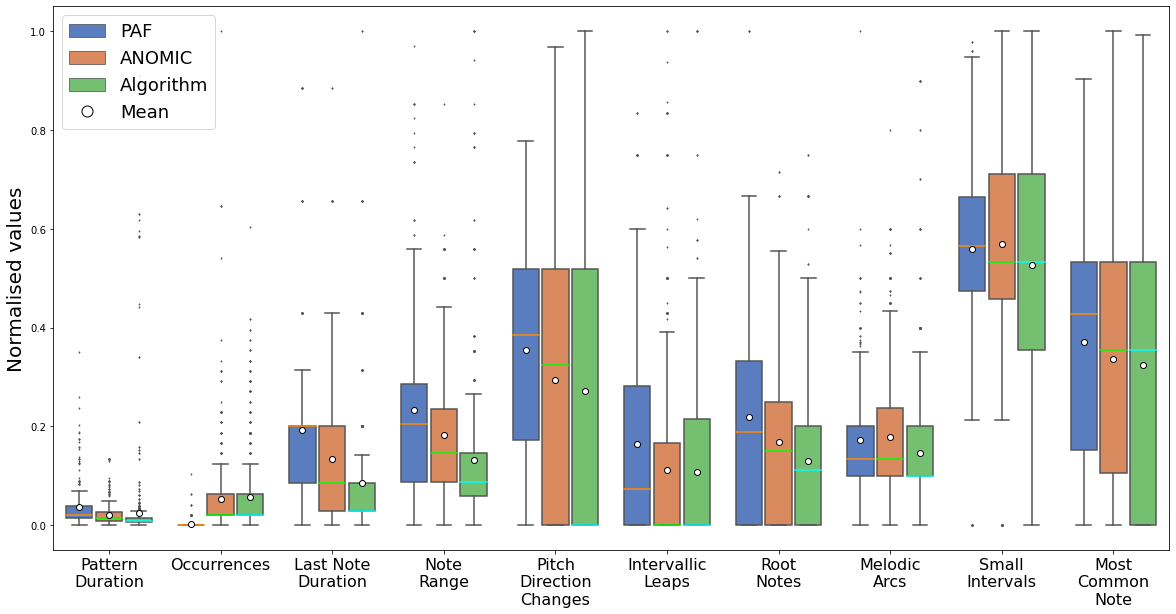

In [26]:
# Multiple boxplots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D
# durations, occurrences, coverage, note_range, pitch changes, 
#intervallic_leaps, root notes, mean_steepness,
# ....
# melodic arcs, small intervals, most common note
section_groups = [['durations','pattern_occurrences',
                   #'coverage',
                   'last_duration',
                   'note_range',
                   'num_of_pitch_direction_changes', 'num_intervallic_leaps', 
                   'roots', #'average_steepness',#],
                  'melodic_arcs', 'num_small_intervals', 'num_of_repeated_notes']]

axis_labels = [['Pattern\nDuration', 'Occurrences',
                #'Coverage',
                'Last Note\nDuration',
              'Note\nRange', 'Pitch\nDirection\nChanges',
              'Intervallic\nLeaps', 'Root\nNotes', #'Mean\nSteepness',#],
              'Melodic\nArcs', 'Small\nIntervals', 'Most\nCommon\nNote']]
##################################################################
def adjust_box_widths(g, fac):
    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    #print("bye")
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        #print("hi")
                        l.set_xdata([xmin_new, xmax_new])

##################################################################

df = []
data_frame_names = ["paf", "anomic", "algorithm"]
show_names = ["PAF", "ANOMIC", "Algorithms"]
for g, group in enumerate(section_groups):
    for i, feature in enumerate(group):
        print(i)
        print(feature)

        all_df_list = [] 
        for j, df_name in enumerate(data_frame_names):
            tmp_df = pd.DataFrame(globals()[df_name+"_"+feature].copy())
            #print(tmp_df)
            tmp_df['key'] = j
            all_df_list.append(tmp_df)

        all_dfs = pd.concat(all_df_list)
        all_dfs = normalize_it(all_dfs)
        #################### 
        # make separate dfs 
        d = {'Group': feature, 
             'value': all_dfs.loc[all_dfs['key'] == 0][0],
             'Dataset': "PAF"}
        df_paf = pd.DataFrame(data=d)
        
        d = {'Group': feature, 
             'value': all_dfs.loc[all_dfs['key'] == 1][0],
             'Dataset': "ANOMIC"}
        df_anomic = pd.DataFrame(data=d)
        
        d = {'Group': feature, 
             'value': all_dfs.loc[all_dfs['key'] == 2][0],
             'Dataset': "Algorithm"}
        df_algorithm = pd.DataFrame(data=d)
        
    
        ##################################################################
        if i == 0:
            df = df_paf.append(df_anomic)
            df = df.append(df_algorithm)
            df = df.reset_index()
            df = df.drop(columns='index')
        else:
            df = df.append(df_paf)
            df = df.append(df_anomic)
            df = df.append(df_algorithm)
            df = df.reset_index()
            df = df.drop(columns='index')
        
    # Plot figure
    fig = plt.figure(figsize=(20,10))#15, 9))

    flierprops = dict(markerfacecolor='0.75', markersize=1,
                  linestyle='none')

    bp = sns.boxplot(x='Group',y='value',
                     data=df,hue='Dataset', flierprops=flierprops,
                     palette="muted", showmeans=True,
                     meanprops={"marker":"o",
                                "markerfacecolor":"white", 
                                "markeredgecolor":"black",
                                "markersize":"6"})
    
    
    
    #flierprops=flierprops)
    #showfliers=False)
    adjust_box_widths(fig, 0.9)
    ax = fig.axes[0]
    ax.set_xticklabels(axis_labels[g], fontsize=16)
    ax.set_xlabel("")
    
    
    ax.set_ylabel("Normalised values", fontsize=20)
    lgd = plt.legend(loc=2, prop={'size': 18})
    
    # add circle to legend 
    #red_circle = Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='r', markersize=15),
    #plt.legend(handles=red_circle)
    
    def add_patch(legend):
        from matplotlib.patches import Patch
        ax = legend.axes
        
        mean_circle = Line2D([0], [0], marker='o', color='w', label='Circle', 
                             markerfacecolor='white', markeredgecolor="black", markersize=11),
        
        handles, labels = ax.get_legend_handles_labels()
        
        handles.append(mean_circle)#Patch(facecolor='white', edgecolor='black'))
        labels.append("Mean")

        legend._legend_box = None
        legend._init_legend_box(handles, labels)
        legend._set_loc(legend._loc)
        legend.set_title(legend.get_title().get_text())

    add_patch(lgd)

    ####################
    # Color the median values
    for line in ax.get_lines()[4::21]:
        line.set_color('darkorange')
    
    for line in ax.get_lines()[11::21]:
        line.set_color('lime')
    
    for line in ax.get_lines()[18::21]:
        line.set_color('cyan')
    print(ax.get_lines())
    ####################
    
    plt.show()

0
durations
1
pattern_occurrences
2
last_duration
3
note_range
4
num_of_pitch_direction_changes
5
num_intervallic_leaps
6
roots


<ipython-input-27-86e1e48b1686>:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


<a list of 98 Line2D objects>


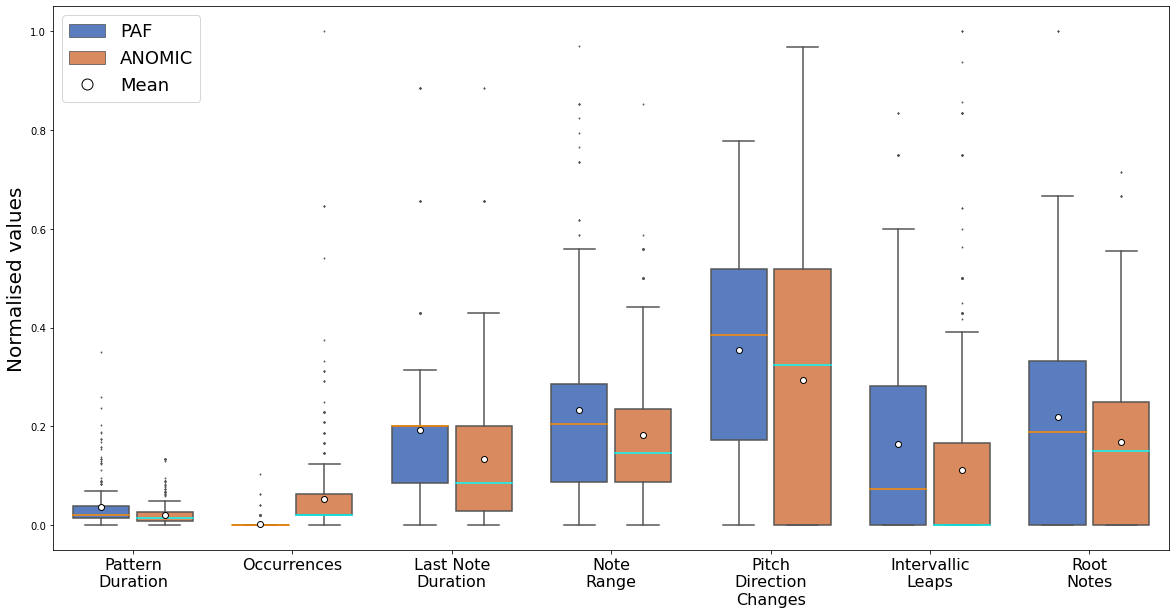

In [27]:
#################################################
# REVISED VERSION
#################################################

# Multiple boxplots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D
# durations, occurrences, coverage, note_range, pitch changes, 
#intervallic_leaps, root notes, mean_steepness,
# ....
# melodic arcs, small intervals, most common note
section_groups = [['durations','pattern_occurrences',
                   #'coverage',
                   'last_duration',
                   'note_range',
                   'num_of_pitch_direction_changes', 'num_intervallic_leaps', 
                   'roots', #'average_steepness',#],
                  ]]#'melodic_arcs', 'num_small_intervals', 'num_of_repeated_notes']]

axis_labels = [['Pattern\nDuration', 'Occurrences',
                #'Coverage',
                'Last Note\nDuration',
              'Note\nRange', 'Pitch\nDirection\nChanges',
              'Intervallic\nLeaps', 'Root\nNotes', #'Mean\nSteepness',#],
               ]]#'Melodic\nArcs', 'Small\nIntervals', 'Most\nCommon\nNote']]
##################################################################
def adjust_box_widths(g, fac):
    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    #print("bye")
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        #print("hi")
                        l.set_xdata([xmin_new, xmax_new])

##################################################################

df = []
data_frame_names = ["paf", "anomic", "algorithm"]
show_names = ["PAF", "ANOMIC", "Algorithms"]
for g, group in enumerate(section_groups):
    for i, feature in enumerate(group):
        print(i)
        print(feature)

        all_df_list = [] 
        for j, df_name in enumerate(data_frame_names):
            tmp_df = pd.DataFrame(globals()[df_name+"_"+feature].copy())
            #print(tmp_df)
            tmp_df['key'] = j
            all_df_list.append(tmp_df)

        all_dfs = pd.concat(all_df_list)
        all_dfs = normalize_it(all_dfs)
        #################### 
        # make separate dfs 
        d = {'Group': feature, 
             'value': all_dfs.loc[all_dfs['key'] == 0][0],
             'Dataset': "PAF"}
        df_paf = pd.DataFrame(data=d)
        
        d = {'Group': feature, 
             'value': all_dfs.loc[all_dfs['key'] == 1][0],
             'Dataset': "ANOMIC"}
        df_anomic = pd.DataFrame(data=d)
        
        d = {'Group': feature, 
             'value': all_dfs.loc[all_dfs['key'] == 2][0],
             'Dataset': "Algorithm"}
        df_algorithm = pd.DataFrame(data=d)
        
    
        ##################################################################
        if i == 0:
            df = df_paf.append(df_anomic)
            #df = df.append(df_algorithm)
            df = df.reset_index()
            df = df.drop(columns='index')
        else:
            df = df.append(df_paf)
            df = df.append(df_anomic)
            #df = df.append(df_algorithm)
            df = df.reset_index()
            df = df.drop(columns='index')
        
    # Plot figure
    fig = plt.figure(figsize=(20,10))#15, 9))

    flierprops = dict(markerfacecolor='0.75', markersize=1,
                  linestyle='none')

    bp = sns.boxplot(x='Group',y='value',
                     data=df,hue='Dataset', flierprops=flierprops,
                     palette="muted", showmeans=True,
                     meanprops={"marker":"o",
                                "markerfacecolor":"white", 
                                "markeredgecolor":"black",
                                "markersize":"6"})
    
    
    
    #flierprops=flierprops)
    #showfliers=False)
    adjust_box_widths(fig, 0.9)
    ax = fig.axes[0]
    ax.set_xticklabels(axis_labels[g], fontsize=16)
    ax.set_xlabel("")
    
    
    ax.set_ylabel("Normalised values", fontsize=20)
    lgd = plt.legend(loc=2, prop={'size': 18})
    
    # add circle to legend 
    #red_circle = Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='r', markersize=15),
    #plt.legend(handles=red_circle)
    
    def add_patch(legend):
        from matplotlib.patches import Patch
        ax = legend.axes
        
        mean_circle = Line2D([0], [0], marker='o', color='w', label='Circle', 
                             markerfacecolor='white', markeredgecolor="black", markersize=11),
        
        handles, labels = ax.get_legend_handles_labels()
        
        handles.append(mean_circle)#Patch(facecolor='white', edgecolor='black'))
        labels.append("Mean")

        legend._legend_box = None
        legend._init_legend_box(handles, labels)
        legend._set_loc(legend._loc)
        legend.set_title(legend.get_title().get_text())

    add_patch(lgd)

    ####################
    # Color the median values
    for line in ax.get_lines()[4::14]:
        line.set_color('darkorange')
    
    for line in ax.get_lines()[11::14]:
        line.set_color('cyan')
    
    #for line in ax.get_lines()[18::21]:
    #    line.set_color('cyan')
    print(ax.get_lines())
    ####################
    
    plt.show()
    

In [28]:
"""
# similar features:
# 1 for each pattern 
cardinality, occurrences,
threeCs, pattern_duration,
last_note_duration,
mean_centered_cardinality_occurrences,
expected_occurrences, 
geometric_mean_likelihood,
score, interest,
prominence, alternative_prominence,
note_range, signed_pitch_range,
unsigned_pitch_range, maximum_pitch_centre,
chromatic, pitch_direction_changes, 
small_intervals, intervallic_leaps,
mean_melodic_interval, root_notes,
thirds, fifths, mean_steepness, 
repeated_notes, 
occurrences_of_most_repeated_note,
unique_notes
# melodic arcs, coverage, 
#rhythmic density, compression ratio 
# 

# 1 for each pattern note 
# rhythmic variability 
"""

'\n# similar features:\n# 1 for each pattern \ncardinality, occurrences,\nthreeCs, pattern_duration,\nlast_note_duration,\nmean_centered_cardinality_occurrences,\nexpected_occurrences, \ngeometric_mean_likelihood,\nscore, interest,\nprominence, alternative_prominence,\nnote_range, signed_pitch_range,\nunsigned_pitch_range, maximum_pitch_centre,\nchromatic, pitch_direction_changes, \nsmall_intervals, intervallic_leaps,\nmean_melodic_interval, root_notes,\nthirds, fifths, mean_steepness, \nrepeated_notes, \noccurrences_of_most_repeated_note,\nunique_notes\n# melodic arcs, coverage, \n#rhythmic density, compression ratio \n# \n\n# 1 for each pattern note \n# rhythmic variability \n'

# Correlation

In [30]:
# Import those libraries 
import pandas as pd 
from scipy.stats import pearsonr, spearmanr
from itertools import combinations

feature_names = ['cardinality', 
                 'pattern_occurrences',
                 'coverage', 'compression_ratio',
                'threeCs', 'rhythmic_density',
                 'durations','last_duration',
                 'melodic_arcs', 
                 'rhythmic_variability',
                'mc_cardinality_occurrences',
                'expected_occurrences', 
                'geometric_mean_likelihood',
                'score', 'interest',
                'prominence', 'alternative_prominence',
                'note_range', 'signed_pitch_range',
                'unsigned_pitch_range',
                'max_pitch_centre',
                'chromatic_nonkey', 
                'num_of_pitch_direction_changes', 
                'num_small_intervals', 'num_intervallic_leaps',
                'mean_melodic_interval', 'roots',
                'thirds', 'fifths', 'average_steepness', 
                'num_of_repeated_notes', 
                'num_of_most_common_note',
                'num_of_different_notes']

display_names = ['Cardinality', 
                 'Occurrences', 'Coverage',
                'Compression ratio',
                'ThreeCs', 'Rhythmic Density',
                'Pattern Duration','Last Note Duration',
                'Melodic Arcs', 
                'Rhythmic Variability',
                'MC Card. $\\times$ Occ.',
                'Exp. Occurrences', 
                'Geo. Mean Likelihood',
                'Score', 'Interest',
                'Prominence', 'Alt. prominence',
                'Note Range', 'Signed Pitch Range',
                'Unsigned Pitch Range',
                'Max. Pitch Centre',
                'Chromatic', 
                'Pitch Direction Changes', 
                'Small Intervals', 'Intervallic Leaps',
                'Mean Melodic Interval', 'Roots',
                'Thirds', 'Fifths', 'Mean Steepness', 
                'Repeated Notes', 
                'Most Common Note',
                'Unique Notes']

feature_names = ['coverage', 
                 'melodic_arcs', 
                 'expected_occurrences', 
                 'geometric_mean_likelihood',
                 'interest',
                 'alternative_prominence',
                 'unsigned_pitch_range',
                'max_pitch_centre',
                'chromatic_nonkey', 
                'num_of_pitch_direction_changes', 
                'num_small_intervals', 'num_intervallic_leaps',
                'mean_melodic_interval', 
                'thirds', 'fifths', 'average_steepness', 
                'num_of_most_common_note',]

display_names = [ 'Coverage',
                'Melodic Arcs', 
                'Exp. Occurrences', 
                'Geo. Mean Likelihood',
                'Interest',
                'Alt. prominence',
                'Unsigned Pitch Range',
                'Max. Pitch Centre',
                'Chromatic', 
                'Pitch Direction Changes', 
                'Small Intervals', 'Intervallic Leaps',
                'Mean Melodic Interval',
                'Thirds', 'Fifths', 'Mean Steepness', 
                'Most Common Note']


############################################
def get_correlations(dataset, combinations):
    names = []
    pearsons = []
    spearmans = []
    
    for c_feat in combinations:
        # get features
        feat_1 = globals()[dataset + "_" + c_feat[0]].copy()
        feat_2 = globals()[dataset + "_" + c_feat[1]].copy()
        
        # sanity check 
        if isinstance(feat_1, pd.DataFrame):
            feat_1 = feat_1[0]

        if isinstance(feat_2, pd.DataFrame):
            feat_2 = feat_2[0]
        
        # get pearson and spearmans 
        pearson_corr, _ = pearsonr(feat_1, feat_2) 
        spearmans_corr, _ = spearmanr(feat_1, feat_2) 
        
        # get names 
        name_0 = display_names[feature_names.index(c_feat[0])]
        name_1 = display_names[feature_names.index(c_feat[1])]
        
        # append results 
        #results.append(pearson_corr)
        names.append([name_0, name_1])
        pearsons.append(pearson_corr)
        spearmans.append(spearmans_corr)
    
    
    dat = {'features': names, 'pearsons': pearsons, 'spearmans':spearmans}
    df_correlation = pd.DataFrame(data=dat)
    df_correlation
    
    return df_correlation
############################################

combinations = list(combinations(feature_names,2))
df_correlation = get_correlations("algorithm", combinations )
output_how_many = 50
# sort by the pearsons value
pears = df_correlation.reindex(df_correlation.pearsons.abs().sort_values(ascending=False).index)[0:output_how_many]

# sort by the pearsons value
spears = df_correlation.reindex(df_correlation.spearmans.abs().sort_values(ascending=False).index)[0:output_how_many]


pears_results = []
spears_results = []
for index, row in pears.iterrows():
    line = """{feat_1} \& {feat_2}& ${val}$ \\\\ """.format(
                                  feat_1=row["features"][0].replace("_", " ").replace("num of ", "\#"),
                                  feat_2=row["features"][1].replace("_", " ").replace("num of ", "\#"),
                                  val="{:.2f}".format(row["pearsons"]))

    pears_results.append(line)
    print(line)
    
print("_______________________________________")
for index, row in spears.iterrows():
    line = """{feat_1} \& {feat_2}& ${val}$ \\\\""".format(
                              feat_1=row["features"][0].replace("_", " ").replace("num of ", "\#"),
                              feat_2=row["features"][1].replace("_", " ").replace("num of ", "\#"),
                              val="{:.2f}".format(row["spearmans"]))
    #line = row["features"][0] + " \& " + row["features"][1] + "& $"+ str(row["pearsons"]) + "$ \ \\" 
    spears_results.append(line)   
    print(line)
    

Mean Melodic Interval \& Mean Steepness& $-0.80$ \\ 
Melodic Arcs \& Most Common Note& $-0.73$ \\ 
Small Intervals \& Mean Melodic Interval& $-0.73$ \\ 
Small Intervals \& Mean Steepness& $0.66$ \\ 
Coverage \& Exp. Occurrences& $-0.66$ \\ 
Alt. prominence \& Chromatic& $0.60$ \\ 
Alt. prominence \& Unsigned Pitch Range& $0.59$ \\ 
Intervallic Leaps \& Mean Melodic Interval& $0.49$ \\ 
Unsigned Pitch Range \& Chromatic& $0.47$ \\ 
Small Intervals \& Intervallic Leaps& $-0.42$ \\ 
Intervallic Leaps \& Mean Steepness& $-0.37$ \\ 
Thirds \& Fifths& $-0.33$ \\ 
Fifths \& Most Common Note& $0.32$ \\ 
Coverage \& Interest& $0.28$ \\ 
Small Intervals \& Most Common Note& $0.26$ \\ 
Chromatic \& Small Intervals& $0.23$ \\ 
Exp. Occurrences \& Geo. Mean Likelihood& $0.21$ \\ 
Max. Pitch Centre \& Fifths& $-0.21$ \\ 
Melodic Arcs \& Fifths& $-0.20$ \\ 
Unsigned Pitch Range \& Max. Pitch Centre& $-0.19$ \\ 
Intervallic Leaps \& Most Common Note& $-0.19$ \\ 
Melodic Arcs \& Unsigned Pitch Range& $

In [45]:
feature_names = ['cardinality', 
                 'pattern_occurrences',
                 'coverage', 'compression_ratio',
                'threeCs', 'rhythmic_density',
                 'durations','last_duration',
                 'melodic_arcs', 
                 'rhythmic_variability',
                'mc_cardinality_occurrences',
                'expected_occurrences', 
                'geometric_mean_likelihood',
                'score', 'interest',
                'prominence', 'alternative_prominence',
                'note_range', 'signed_pitch_range',
                'unsigned_pitch_range',
                'max_pitch_centre',
                'chromatic_nonkey', 
                'num_of_pitch_direction_changes', 
                'num_small_intervals', 'num_intervallic_leaps',
                'mean_melodic_interval', 'roots',
                'thirds', 'fifths', 'average_steepness', 
                'num_of_repeated_notes', 
                'num_of_most_common_note',
                'num_of_different_notes']

output_names = ['Cardinality', 
                 'Occurrences', 'Coverage',
                'Compression ratio',
                'ThreeCs', 'Rhythmic Density',
                'Pattern Duration','Last Note Duration',
                'Melodic Arcs', 
                'Rhythmic Variability',
                'MC Card. $\\times$ Occ.',
                'Expected Occurrences', 
                'Geo. Mean Likelihood',
                'Score', 'Interest',
                'Prominence', 'Alternative prominence',
                'Note Range', 'Signed Pitch Range',
                'Unsigned Pitch Range',
                'Maximum Pitch Centre',
                'Chromatic', 
                'Pitch Direction Changes', 
                'Small Intervals', 'Intervallic Leaps',
                'Mean Melodic Interval', 'Roots',
                'Thirds', 'Fifths', 'Mean Steepness', 
                'Repeated Notes', 
                'Most Common Note',
                'Unique Notes']

y_axis = ['Number of events', 'Number of occurrences', 'Coverage of a pattern',
         'Compression ratio', 'ThreeCs value', 'Mean number of events per tactus beat',
         'Quarter notes', 'Quarter notes', 'Quarter notes',
         'Degree of change in note duration', 'Mean Centered Cardinality $\\times$ Occurrences',
         'Expected Occurrences', 'Geomentric Mean Likelihood', 'Score', 'Interest', 'Prominence',
         'Alternative Prominence', 'MIDI Note Numbers', 'MIDI Note Numbers', 'MIDI Note Numbers',
         'MIDI Note Numbers', 'Number of Nonkey Notes', 'Number of Pitch Direction Changes',
         'Fraction of Small Intervals', 'Fraction of Intervallic Leaps', 'Mean Melodic Interval',
         'Fraction of Root Notes', 'Fraction of Major or Minor Thirds', 'Fraction of Perfect Fifths',
         'Mean Steepness', 'Number of Repeated Notes', 'Number of Occurrences of the Most Common Note',
         'Number of Unique Notes']

which_are_zeros = []

for i, feat in enumerate(feature_names):
    p = globals()["paf_"+ feat]
    # TODO TODO TODO CHANGES HERE
    a = globals()["anomic_"+ feat]
    alg = globals()["algorithm_"+ feat]
    
    p = pd.DataFrame(p)
    a = pd.DataFrame(a)
    alg = pd.DataFrame(alg)

    name = output_names[i]
    y_name = y_axis[i]
    
    print_everything(name, p, a, alg, 1, 1, feat, y_name, feat)

Cardinality & $10.21$ ($12.02$)  &  $7.64$ ($6.88$)  &  $6.32$ ($10.3$)  \\
Occurrences & $1.14$ ($0.49$)  &  $3.52$ ($3.56$)  &  $3.76$ ($3.31$)  \\
Coverage & $11.88$ ($13.65$)  &  $22.2$ ($18.47$)  &  $21.61$ ($30.45$)  \\
Compression ratio & $2.24$ ($3.23$)  &  $2.82$ ($2.7$)  &  $3.25$ ($4.62$)  \\
ThreeCs & $60.08$ ($174.11$)  &  $99.13$ ($198.64$)  &  $187.11$ ($1029.16$)  \\
Rhythmic Density & $4.76$ ($2.2$)  &  $5.24$ ($2.61$)  &  $4.4$ ($3.26$)  \\
Pattern Duration & $6.58$ ($7.71$)  &  $3.97$ ($3.75$)  &  $4.78$ ($17.16$)  \\
Last Note Duration & $0.97$ ($0.68$)  &  $0.72$ ($0.53$)  &  $0.5$ ($0.48$)  \\
Melodic Arcs & $1.72$ ($1.2$)  &  $1.78$ ($1.36$)  &  $1.46$ ($1.32$)  \\
Rhythmic Variability & $0.41$ ($0.28$)  &  $0.36$ ($0.3$)  &  $0.3$ ($0.35$)  \\
MC Card. $\times$ Occ. & $0.0$ ($12.02$)  &  $-0.0$ ($6.88$)  &  $0.0$ ($10.3$)  \\
Expected Occurrences & $52.51$ ($17.23$)  &  $57.19$ ($14.21$)  &  $62.64$ ($12.55$)  \\
Geo. Mean Likelihood & $0.09$ ($0.05$)  &  $0.09$

In [32]:
"""
groups_patterns = df_algorithm_patterns.groupby(['user_id','song_id','pattern_id'])
    
densities = []
i = 0
for name_pat, group_pat in groups_patterns:
    song_id =  group_pat['song_id'].iloc[0]

    all_pattern_times = group_pat['note_times']
    if len(all_pattern_times) > 1:
        print(all_pattern_times)
        print("#")
        print(group_pat['note_numbers'])
        print("...")
    i += 1
"""

'\ngroups_patterns = df_algorithm_patterns.groupby([\'user_id\',\'song_id\',\'pattern_id\'])\n    \ndensities = []\ni = 0\nfor name_pat, group_pat in groups_patterns:\n    song_id =  group_pat[\'song_id\'].iloc[0]\n\n    all_pattern_times = group_pat[\'note_times\']\n    if len(all_pattern_times) > 1:\n        print(all_pattern_times)\n        print("#")\n        print(group_pat[\'note_numbers\'])\n        print("...")\n    i += 1\n'

425

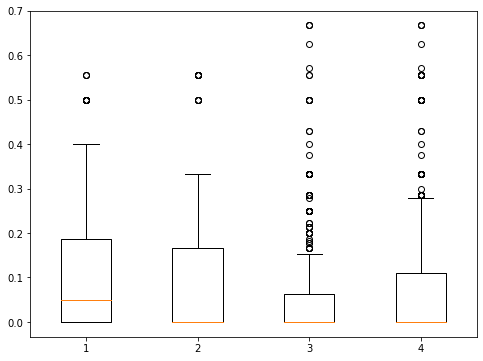

In [34]:
fig = plt.figure(figsize=(8,6))
f = "num_intervallic_leaps"             
    
a = globals()["paf_" +f][0]
b = globals()["mus_" +f][0]
c = globals()["nonmus_" +f][0] 
d = globals()["anomic_" +f][0]
plt.boxplot([a, b, c, d] )

len(mus_last_duration)
len(nonmus_last_duration)

In [36]:

#print(t_test(mus_last_duration[0], nonmus_last_duration[0]))
#ks_test(mus_last_duration[0], nonmus_last_duration[0])

In [43]:
fs = ["duration",
"last_duration",
"note_range",
"num_of_pitch_direction_changes",
"num_intervallic_leaps",
"roots",
"average_steepness"]

for f in fs:
    #print(globals()["mus_"+f])
    a = globals()["paf_" +f]
    b = globals()["anomic_" +f]
    c = globals()["algorithm_" +f]
    m = globals()["mus_" +f]
    nm = globals()["nonmus_" +f]
    
    print(f + ":")
    # LAST NOTE DURATIONS 
    make_all_t_tests("", a[0], b[0], c[0])
    make_all_t_tests("", a[0], m[0], nm[0])
    print("....................")
    make_all_ks_tests("", a, b, c)
    make_all_ks_tests("", a, m, nm)
    print("_________________________")

duration:
 & $7.54$ ($9.60e-14$)  & \cellcolor{orange!25} $1.83$ ($6.76e-02$)  & \cellcolor{orange!25} $-1.3$ ($1.94e-01$)  \\
 & $4.06$ ($5.38e-05$)  & $7.68$ ($5.09e-14$)  & $4.91$ ($1.09e-06$)  \\
....................
 & $0.2$ ($4.07e-08$)  & $0.47$ ($7.71e-52$)  & $0.29$ ($4.44e-16$)  \\
 & $0.13$ ($4.65e-03$)  & $0.28$ ($5.69e-13$)  & $0.22$ ($1.60e-08$)  \\
_________________________
last_duration:
 & $6.75$ ($2.45e-11$)  & $14.1$ ($2.33e-42$)  & $9.21$ ($8.68e-20$)  \\
 & $3.93$ ($9.30e-05$)  & $7.36$ ($4.90e-13$)  & $3.49$ ($5.15e-04$)  \\
....................
 & $0.23$ ($1.20e-10$)  & $0.49$ ($1.48e-56$)  & $0.27$ ($4.44e-16$)  \\
 & $0.17$ ($8.34e-05$)  & $0.27$ ($2.32e-12$)  & $0.12$ ($7.79e-03$)  \\
_________________________
note_range:
 & $5.18$ ($2.57e-07$)  & $10.89$ ($1.39e-26$)  & $7.8$ ($9.89e-15$)  \\
 & \cellcolor{orange!25} $1.62$ ($1.05e-01$)  & $6.87$ ($1.36e-11$)  & $6.15$ ($1.23e-09$)  \\
....................
 & $0.12$ ($2.07e-03$)  & $0.35$ ($4.76e-28$)  & $0.2

In [39]:
f = "num_intervallic_leaps"

a = globals()["paf_" +f]
b = globals()["mus_" +f]
c = globals()["nonmus_" +f]
d = globals()["anomic_" +f]

"""
print(mean(a), np.std(a), "\n",
      mean(b), np.std(b), "\n", 
      mean(c), np.std(c), "\n", 
      mean(d), np.std(d))
"""
print(a.mean()[0], np.std(a)[0], "\n",
      b.mean()[0], np.std(b)[0], "\n", 
      c.mean()[0], np.std(c)[0], "\n", 
      d.mean()[0], np.std(d)[0])

print("Median:",a.median()[0] ,d.median()[0])

0.10918816338653434 0.13742119730415922 
 0.08882065879698117 0.1336363333862868 
 0.06276245195919762 0.13039461530604604 
 0.07465858986340324 0.13252159419537082
Median: 0.04880952380952381 0.0


In [40]:
nonmus_durations.mean()

0    3.379377
dtype: float64

# Plot all boxplots separately

cardinality
pattern_occurrences
coverage
compression_ratio
threeCs
rhythmic_density
durations
last_duration
melodic_arcs
rhythmic_variability
mc_cardinality_occurrences
expected_occurrences
geometric_mean_likelihood
score
interest
prominence
alternative_prominence
note_range
signed_pitch_range
unsigned_pitch_range
max_pitch_centre
chromatic_nonkey


<ipython-input-16-ad1557bfab5f>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,6))


num_of_pitch_direction_changes
num_small_intervals
num_intervallic_leaps
mean_melodic_interval
roots
thirds
fifths
average_steepness
num_of_repeated_notes
num_of_most_common_note
num_of_different_notes


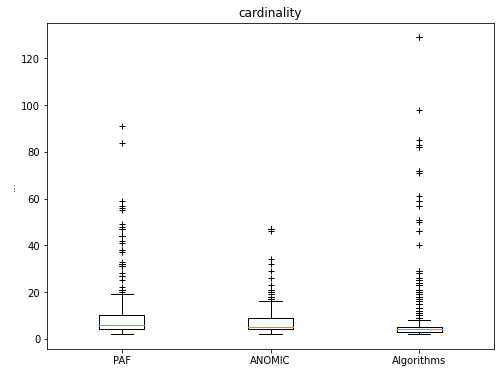

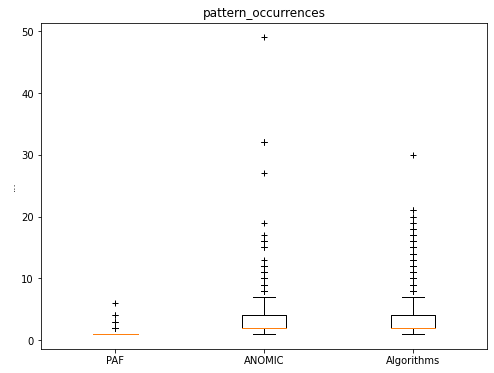

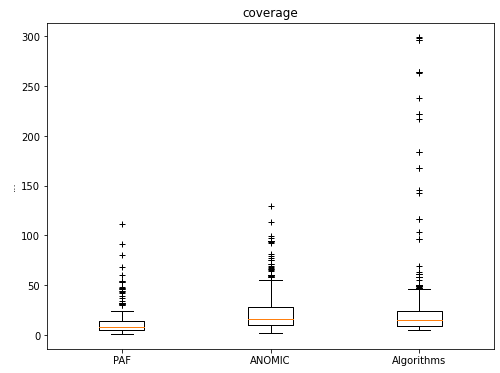

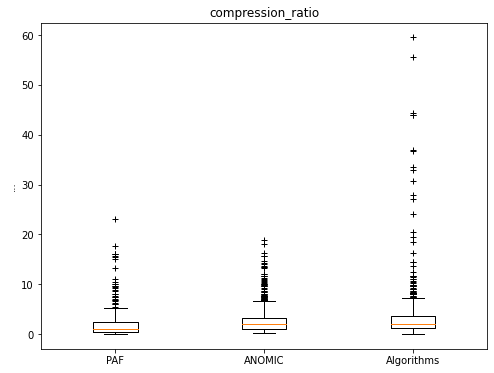

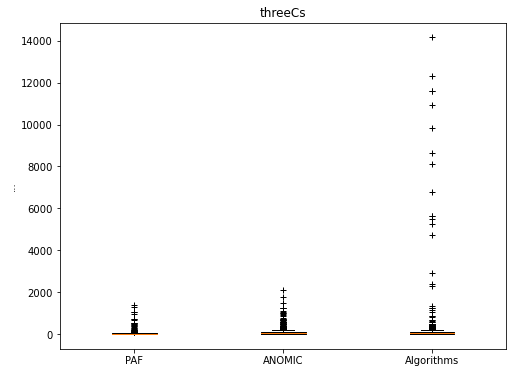

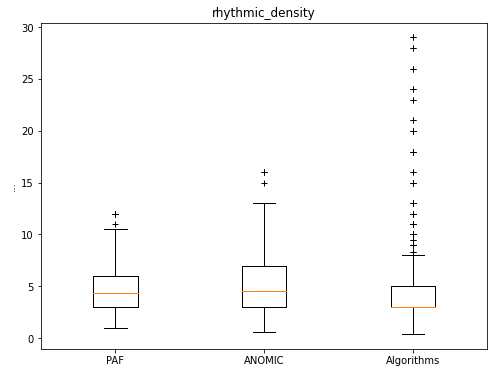

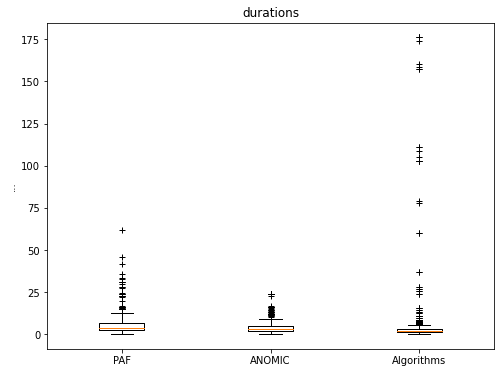

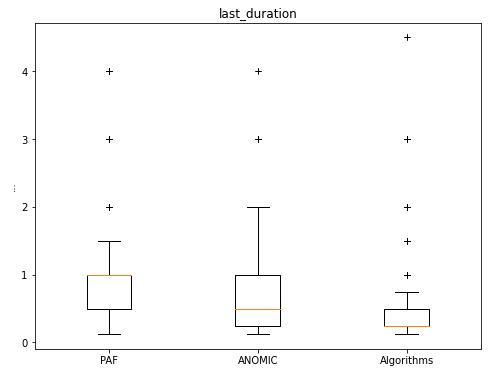

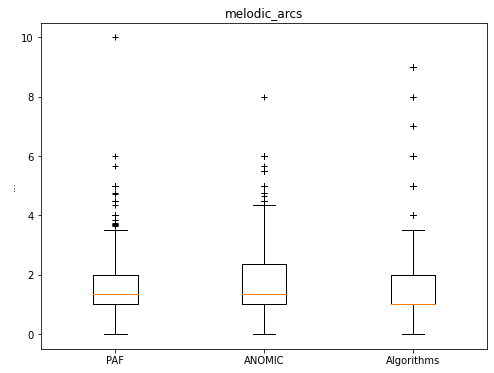

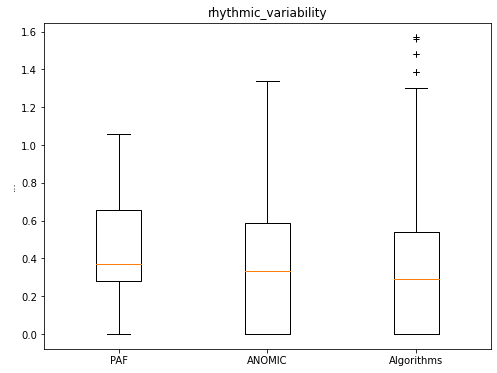

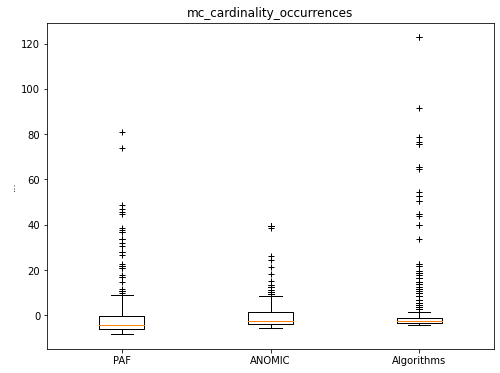

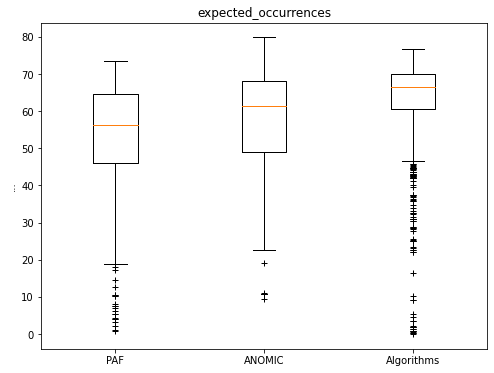

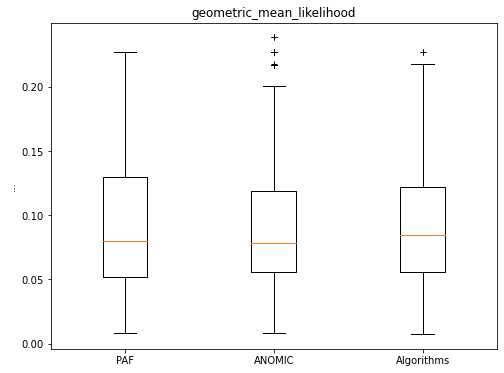

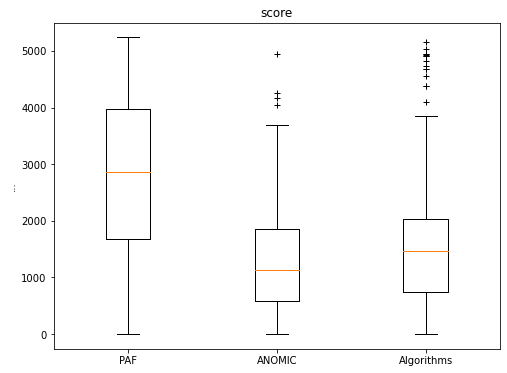

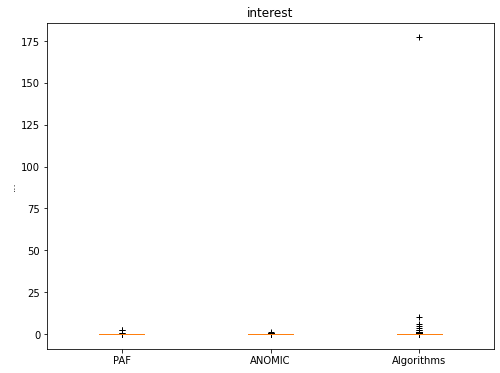

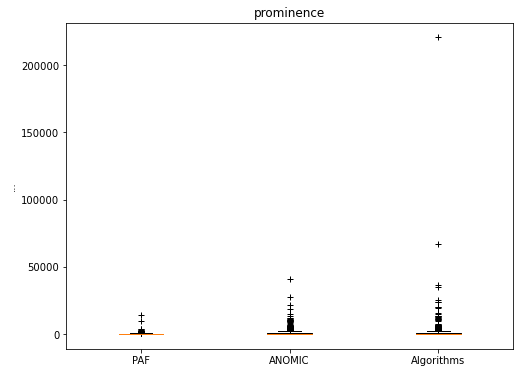

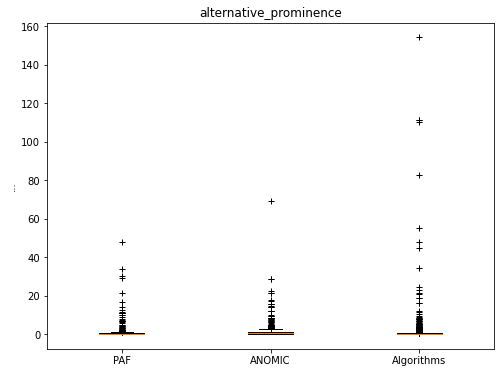

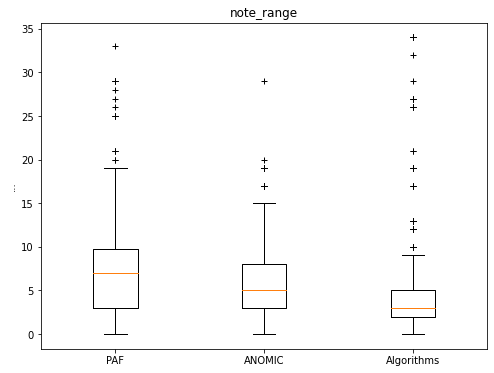

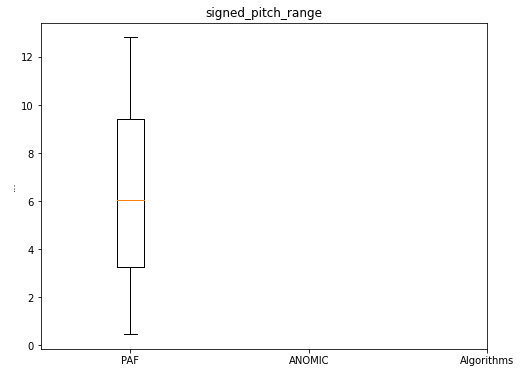

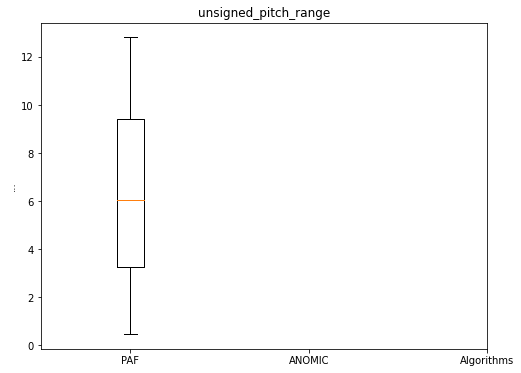

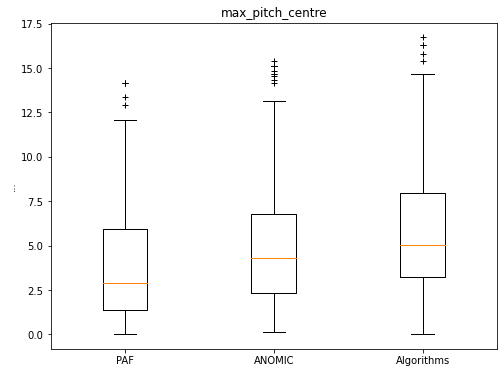

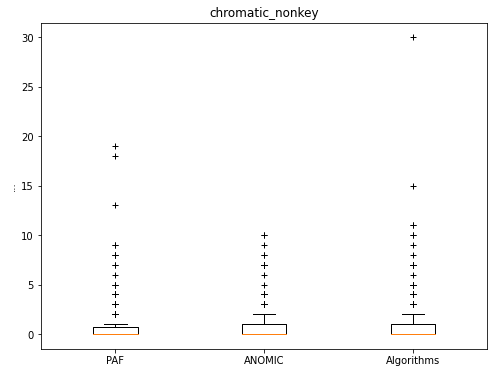

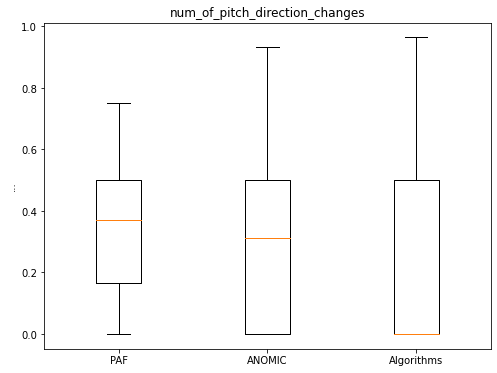

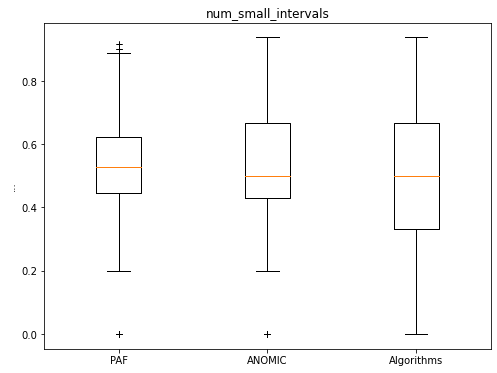

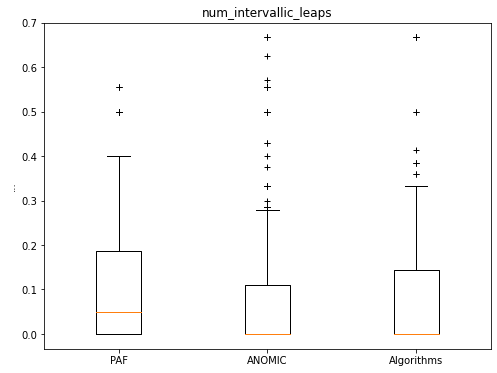

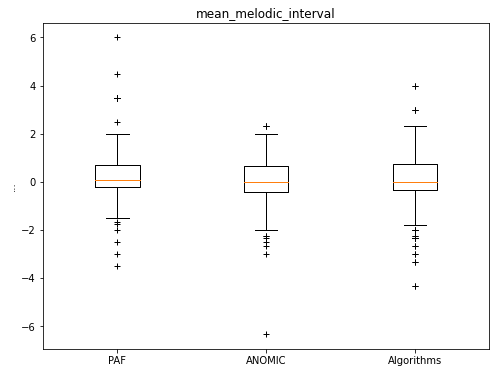

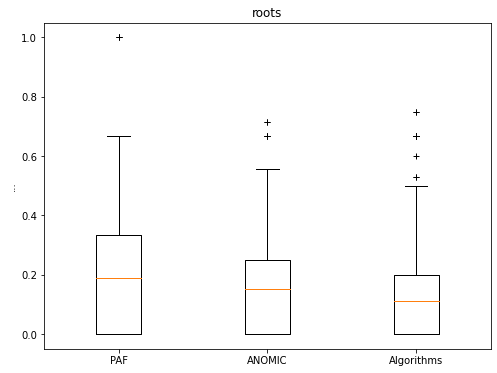

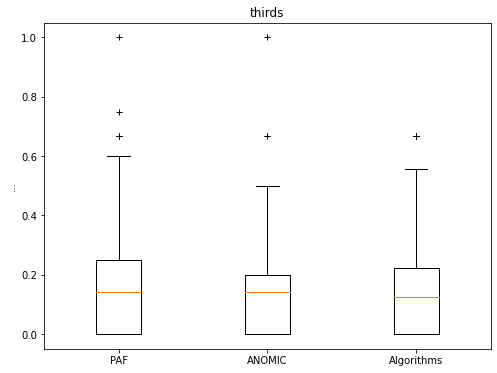

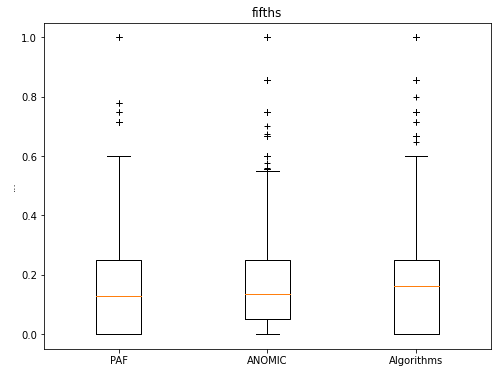

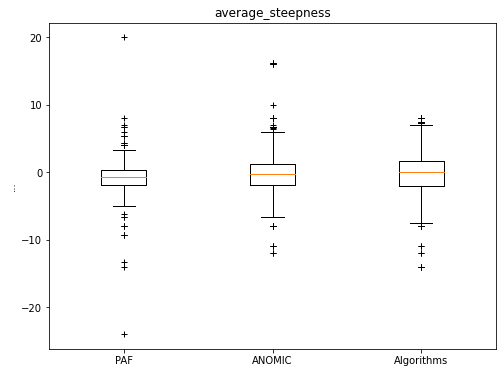

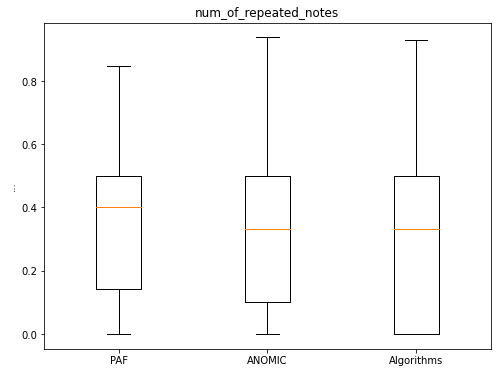

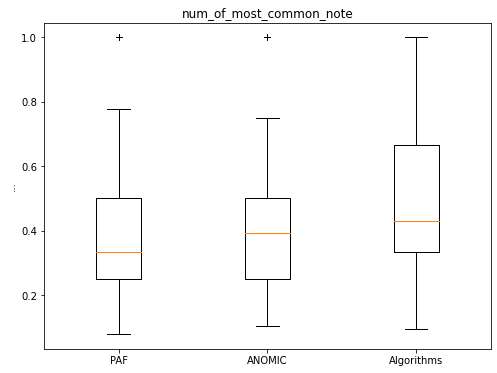

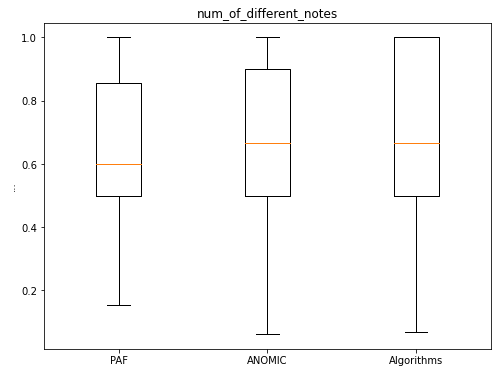

In [55]:
fs = ['cardinality', 
     'pattern_occurrences',
     'coverage', 'compression_ratio',
    'threeCs', 'rhythmic_density',
     'durations','last_duration',
     'melodic_arcs', 
     'rhythmic_variability',
    'mc_cardinality_occurrences',
    'expected_occurrences', 
    'geometric_mean_likelihood',
    'score', 'interest',
    'prominence', 'alternative_prominence',
    'note_range', 'signed_pitch_range',
    'unsigned_pitch_range',
    'max_pitch_centre',
    'chromatic_nonkey', 
    'num_of_pitch_direction_changes', 
    'num_small_intervals', 'num_intervallic_leaps',
    'mean_melodic_interval', 'roots',
    'thirds', 'fifths', 'average_steepness', 
    'num_of_repeated_notes', 
    'num_of_most_common_note',
    'num_of_different_notes']

# 
for f in fs:
    #print(globals()["mus_"+f])
    a = globals()["paf_" +f]
    b = globals()["anomic_" +f]
    c = globals()["algorithm_" +f]
    m = globals()["mus_" +f]
    nm = globals()["nonmus_" +f]
    
    print(f)
    if  isinstance(a, list): 
        make_boxplot([a, b, c], f, "...", "..") 
        
    else:
        make_boxplot( [a[0], b[0], c[0]], f, "...", "..")